# Data analysis approach for characterizing residential energy consumption based on statistics of household appliances ownership

The following analysis is part of the article "Data analysis approach for characterizing residential energy consumption based on statistics of household appliances ownership", extension of the short communication presented at the 1st International Workshop on Advanced Information and Computation Technologies and Systems presented in the AICTS 2020 workshop.

## Load the needed libraries

In [1]:
# python
import datetime
from typing import List, Tuple, Union
import glob
from os.path import join, exists
from os import makedirs
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import ciso8601

# import geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print("Pandas version {}".format(pd.__version__))

Populating the interactive namespace from numpy and matplotlib
Pandas version 1.2.1


/Users/jp/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Declare dataset paths

In [2]:
CONSUM_DATA_PATH = "../data/mean-consum-byarea"
MAPS_PATH = "../data/mapas2011"
INE_ECH_DATASET_PATH = "../data/ech2019"


## Load ECH data

In [3]:
# Columns to use
cols_geo = ['dpto', 'nomdpto', 'secc', 'segm', 'nombarrio', 'region_4']
cols_appl = [
    'd21_1', 'd21_2', 'd21_3', 'd21_4', 'd21_5', 'd21_6',
    #  'd21_8',  REMOVED IN ECH-2019
    'd21_9',
    'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_15'
]
cols_qty_appl = ['d21_4_1', 'd21_5_1', 'd21_14_1', 'd21_15_2', 'd21_15_4']
col_other = ['d9', 'd18', 'd260', 'd20']
ech_cols = cols_geo + cols_appl + cols_qty_appl + col_other

df_ech = pd.read_csv(
    INE_ECH_DATASET_PATH + '/H_2019_Terceros.dat',
    index_col=0,
    delimiter='\t',
    encoding='latin1',
    usecols=ech_cols,
)

from IPython.display import display
pd.options.display.max_columns = 50

df_ech.head()

,nomdpto,secc,segm,nombarrio,region_4,d9,d18,d260,d20,d21_1,d21_2,d21_3,d21_4,d21_4_1,d21_5,d21_5_1,d21_6,d21_9,d21_10,d21_11,d21_12,d21_13,d21_14,d21_14_1,d21_15,d21_15_2,d21_15_4
dpto,,,,,,,,,,,,,,,,,,,,,,,,,,,
14,ROCHA,0,0,,2,2,1,5,3,1,2,1,2,0,1,1,1,2,1,2,2,2,2,0,2,0,0
15,SALTO,0,0,,3,4,1,1,1,1,2,1,1,1,1,1,1,2,1,2,2,1,1,1,2,0,0
1,MONTEVIDEO,11,209,Ituzaingo,1,2,1,1,3,2,1,1,2,0,1,1,1,2,1,2,2,2,2,0,1,1,0
1,MONTEVIDEO,7,206,Cordon,1,3,1,1,3,1,2,1,2,0,1,1,2,2,1,2,2,1,1,1,1,0,1
3,CANELONES,0,0,,2,4,1,3,3,1,2,1,2,0,1,3,2,2,1,2,2,1,1,1,1,0,1


### Data cleansing and formatting

#### Null values validation

In [4]:
# NULL data
df_ech["secc"] = pd.to_numeric(df_ech["secc"], errors='coerce')
df_ech["segm"] = pd.to_numeric(df_ech["segm"], errors='coerce')
df_ech["nombarrio"] = df_ech.nombarrio.apply(lambda x: np.nan if (isinstance(x, str) and x.strip() == "") else x)
# df_ech.isnull().sum().transpose()

NOTE 1: Records corresponding to departments other than Montevideo does not count with section, segment or neighborhood name information.

NOTE 2: Apart from the columns section and segment for records corresponding to other departments than Montevideo, no other column presents null values.

#### Format Yes/No columns

Yes/No columns have 1 and 2 as possible values. To ease the use of the data, the following code transform the values to 0 in case o No and 1 in case of Yes.

In [5]:
for col in cols_appl:
    df_ech[col] = df_ech[col].map({1: 1, 2: 0})

In [6]:
# Validate that all possible values are 0 or 1.
for col in cols_appl:
    if df_ech[(df_ech[col] != 0) & (df_ech[col] != 1)].shape[0] > 0:
        print("Column {} has incompatible values".format(col))
        break
else:
    print("No incompatible values were found")

No incompatible values were found


#### Creation of total number of notebooks column

The following code build a new column with name "d21_15_qty" that have the total number of notebook, i.e., the sum of normal notebooks and "Plan Ceibal" notebooks.

In [7]:
df_ech['d21_15_cant'] = df_ech['d21_15_2'] + df_ech['d21_15_4']
# remove the old columns from columns list
cols_qty_appl.remove('d21_15_2')
cols_qty_appl.remove('d21_15_4')
cols_qty_appl.append('d21_15_cant')

#### Validation of quantity columns

In [8]:
for col in cols_qty_appl:
    # Validate numbers are not negative or over 10 (considered outliners by rule of thumb)
    count_outrange = df_ech[(0 > df_ech[col]) & (df_ech[col] > 10)][col].count()
    if count_outrange:
        print("Column {}: {} values out of range.".format(col, count_outrange))
    else:
        print("Column {}: No values are out of range.".format(col))

    # Validate that if column Yes/No is set to Yes, quantity is between 1 and 10
    elem_confort_colname = '_'.join(col.split('_')[:-1])
    count_outrange = df_ech[(df_ech[elem_confort_colname] == 1) & ((df_ech[col] < 1) | (df_ech[col] > 10))][col].count()
    if count_outrange:
        print("Column {}: {} is set to Yes but {} rows present a quantity value out of range".format(
            col, elem_confort_colname, count_outrange
        ))
        
    # Validate that if column Yes/No is set to No, quantity is exactly 0
    count_outrange = df_ech[(df_ech[elem_confort_colname] == 0) & (df_ech[col] > 0)][col].count()
    if count_outrange:
        print("Column {}: {} is set to No but {} rows present a quantity value different to zero".format(
            col, elem_confort_colname, count_outrange
        ))

Column d21_4_1: No values are out of range.
Column d21_5_1: No values are out of range.
Column d21_14_1: No values are out of range.
Column d21_15_cant: No values are out of range.
Column d21_15_cant: d21_15 is set to Yes but 2625 rows present a quantity value out of range


In [9]:
# Study the outrage value
df_ech[(df_ech[elem_confort_colname] == 1) & ((df_ech[col] < 1) | (df_ech[col] > 10))]

,nomdpto,secc,segm,nombarrio,region_4,d9,d18,d260,d20,d21_1,d21_2,d21_3,d21_4,d21_4_1,d21_5,d21_5_1,d21_6,d21_9,d21_10,d21_11,d21_12,d21_13,d21_14,d21_14_1,d21_15,d21_15_2,d21_15_4,d21_15_cant
dpto,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,SALTO,0,0,NaN,2,4,1,5,3,1,0,1,0,0,1,2,1,0,1,0,0,1,1,1,1,0,0,0
9,LAVALLEJA,0,0,NaN,2,3,1,5,3,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
9,LAVALLEJA,0,0,NaN,2,2,1,5,3,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0
10,MALDONADO,0,0,NaN,4,4,1,5,3,1,0,1,0,0,1,1,1,0,1,0,0,1,1,1,1,0,0,0
19,TREINTA Y TRES,0,0,NaN,2,3,1,5,3,1,0,1,0,0,1,2,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,MALDONADO,0,0,NaN,3,3,1,5,3,1,0,1,0,0,1,2,1,0,1,1,0,1,1,1,1,0,0,0
16,SAN JOSE,0,0,NaN,2,4,1,5,3,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0
1,MONTEVIDEO,17,239,"Manga, Toledo Chico",1,4,1,3,3,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0


We can observe that column "d21_15_4" is set to 7, what makes sense given that it is the number of "Plan Ceibal" notebooks and are free notebooks given by the government. The quantity in column "d21_15_2" is 4, which indicates that, apart of "Plan Ceibal" notebooks, the household count with another 4 notebooks. The row is kept in the data set.

#### Transform lighting, heating and cooking columns to valuable data

**Lighting** data will count one pulp per residential room. **Heating** data will be 1 if the heater system uses electricity and 0 otherwise. Same for the **cooking** system, 1 if use electricity, 0 otherwise.

In [10]:
# Lighting
df_ech["d18"] = df_ech["d18"].map({1: 1}).fillna(0) * df_ech["d9"]

# Heating
df_ech["d260"] = df_ech["d260"].map({1: 1}).fillna(0)

# Cooking
df_ech["d20"] = df_ech["d20"].map({1: 1}).fillna(0)

#### Assure counting once the air conditioner

If the air conditioner is Yes, does not count it in the heater indicator again. It results in column "d260" indicating the presence of heaters that are not an air conditioner.

In [11]:
df_ech.loc[(df_ech['d21_14'] == 1) & (df_ech['d260'] == 1), 'd260'] = 0

#### Integrate the countable columns to the Yes/No column

The result of this final step is the real number of the appliance described by the column.

In [12]:
for col_qty in cols_qty_appl:
    col_appl = "_".join(col_qty.split("_")[:-1])  # Takes until the last "_"
    df_ech[col_appl] = df_ech[col_qty] * df_ech[col_appl]
    print("Column {} was multiplied by the value in column {}".format(col_appl, col_qty))
df_ech.drop(columns=cols_qty_appl, inplace=True)

display(df_ech)

Column d21_4 was multiplied by the value in column d21_4_1
Column d21_5 was multiplied by the value in column d21_5_1
Column d21_14 was multiplied by the value in column d21_14_1
Column d21_15 was multiplied by the value in column d21_15_cant


,nomdpto,secc,segm,nombarrio,region_4,d9,d18,d260,d20,d21_1,d21_2,d21_3,d21_4,d21_5,d21_6,d21_9,d21_10,d21_11,d21_12,d21_13,d21_14,d21_15,d21_15_2,d21_15_4
dpto,,,,,,,,,,,,,,,,,,,,,,,,
14,ROCHA,0,0,NaN,2,2,2.0,0.0,0.0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0
15,SALTO,0,0,NaN,3,4,4.0,0.0,1.0,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0
1,MONTEVIDEO,11,209,Ituzaingo,1,2,2.0,1.0,0.0,0,1,1,0,1,1,0,1,0,0,0,0,1,1,0
1,MONTEVIDEO,7,206,Cordon,1,3,3.0,0.0,0.0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,1
3,CANELONES,0,0,NaN,2,4,4.0,0.0,0.0,1,0,1,0,3,0,0,1,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,COLONIA,0,0,NaN,2,3,3.0,0.0,0.0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0
1,MONTEVIDEO,10,75,Carrasco,1,6,6.0,0.0,0.0,1,0,1,0,1,1,0,1,0,1,1,2,1,0,1
1,MONTEVIDEO,99,53,"Maro¦as, Parque Guarani",1,4,4.0,0.0,0.0,1,0,1,2,1,1,0,1,0,0,1,1,1,0,1


## Build list of appliances information 

In [13]:
# Consumption data (in Watts) of each appliance
appl_consum = pd.DataFrame.from_dict(
    {
        'lighting': [2, 7, 5, 15, 30],
        'heating': [900, 600, 1500, 1000, 2000],
        'oven': [1000, 1500, 1200, 1200, 2000],
        'electric water heater': [1500, 1500, 1700, 1500, 1800],
        'shower heater': [2200, 1500,  1850,  1500, 2000],
        'fridge': [130,  287,  220,  180,  180],
        'tube TV': [100,  120,  108,  166,  130],
        'flat TV': [50,  140,  149,  32,  57],
        'radio': [5, 50, 30, 12, 4],
        'VHS player': [10],
        'DVD player': [12, 9],
        'washing machine': [330, 350, 950, 1050, 1020],
        'clothes dryer': [1070, 3500, 2200, 4200, 4800],
        'dishwasher': [1380, 1800, 1148, 1740, 980],
        'microwave': [1200, 2000, 640, 700, 800],
        'air conditioner': [1600, 900, 2000, 1050, 900],
        'notebook': [65, 90, 63, 45, 22]
    },
    orient='index', columns=['c1', 'c2', 'c3', 'c4', 'c5']
)

# Appliance frequency of use (low, medium, high)
appl_freq = pd.DataFrame.from_dict(
    {
        'lighting': 'medium',
        'heating': 'high',
        'oven': 'high',
        'electric water heater': 'high',
        'shower heater': 'medium',
        'fridge': 'high',
        'tube TV': 'medium',
        'flat TV': 'medium',
        'radio': 'low',
        'VHS player': 'low',
        'DVD player': 'low',
        'washing machine': 'medium',
        'clothes dryer': 'medium',
        'dishwasher': 'medium',
        'microwave': 'medium',
        'air conditioner': 'high',
        'notebook': 'medium'
    },
    orient='index', columns=['frequency']
)

# Map between appliance name and corresponding column name
appl_codename = pd.DataFrame.from_dict(
    {
        'lighting': 'd18',
        'heating': 'd260',
        'oven': 'd20',
        'electric water heater': 'd21_1',
        'shower heater': 'd21_2',
        'fridge': 'd21_3',
        'tube TV': 'd21_4',
        'flat TV': 'd21_5',
        'radio': 'd21_6',
        'VHS player': 'd21_8',
        'DVD player': 'd21_9',
        'washing machine': 'd21_10',
        'clothes dryer': 'd21_11',
        'dishwasher': 'd21_12',
        'microwave': 'd21_13',
        'air conditioner': 'd21_14',
        'notebook': 'd21_15'
    },
    orient='index', columns=['codename']
)

,,mean_consum,std_consum,frequency,mean_consum_weighed,std_consum_weighed
,codename,,,,,
lighting,d18,11.8,11.256109,medium,8.85,8.442082
heating,d260,1200.0,552.268051,high,1200.00,552.268051
oven,d20,1380.0,389.871774,high,1380.00,389.871774
electric water heater,d21_1,1600.0,141.421356,high,1600.00,141.421356
shower heater,d21_2,1810.0,309.030743,medium,1357.50,231.773057
fridge,d21_3,199.4,58.453400,high,199.40,58.453400
tube TV,d21_4,124.8,25.713810,medium,93.60,19.285357
flat TV,d21_5,85.6,54.628747,medium,64.20,40.971560
radio,d21_6,20.2,19.651972,low,10.10,9.825986


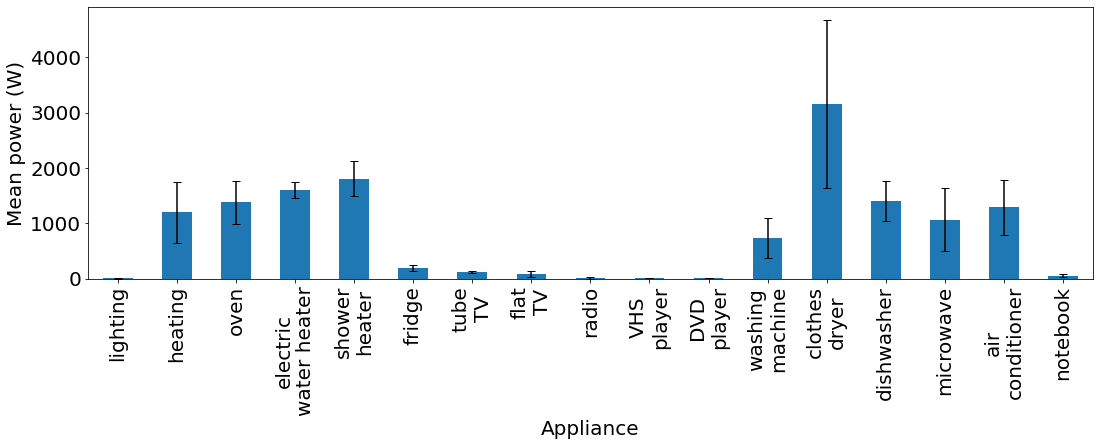

In [14]:
matplotlib.rcParams.update({'font.size': 20})

# Appliances mean consumption
appl_mean_consum = pd.DataFrame(
#     [
    {
        "mean_consum": appl_consum.mean(skipna=True, numeric_only=True, axis='columns'),
        "std_consum": appl_consum.std(skipna=True, numeric_only=True, axis='columns').fillna(0),
    }
)

# Join the column name, frequancy and mean consumption data, and set column names as index
appl_total_info = appl_mean_consum.join(
    appl_freq.join(appl_codename)
).set_index('codename', append=True)

# Add mean consumption weighed by the frequency
# The follow values are added to the three frequencies: 'low': 0.5, 'medium': 0.75, 'high': 1
appl_total_info['mean_consum_weighed'] = (
    appl_total_info['mean_consum'] * 
    appl_total_info['frequency'].map({'low': 0.5, 'medium': 0.75, 'high': 1})
)
appl_total_info['std_consum_weighed'] = (
    appl_total_info['std_consum'] * 
    appl_total_info['frequency'].map({'low': 0.5, 'medium': 0.75, 'high': 1})
)

ax = appl_total_info.mean_consum.plot.bar(
    x=appl_total_info.index.get_level_values(0), yerr=appl_total_info.std_consum, rot=90, capsize=4
)
ax.set_xticklabels([x.replace(" ", "\n", 1) for x in appl_total_info.index.get_level_values(0)])
ax.set_xlabel("Appliance")
ax.set_ylabel("Mean power (W)")

display(appl_total_info)

# appl_total_info.mean_consum_weighed.plot.bar(x=appl_total_info.index, yerr=appl_total_info.std_consum_weighed)

## Load maps data

In [15]:
# Set the coordinates system used by INE (wgs-84-utm-zone-21s)
# EPSG:32721 (http://www.spatialreference.org/ref/epsg/wgs-84-utm-zone-21s/)
crs = {'init': 'epsg:32721'}

# Departments
filePath = MAPS_PATH + "/ine_depto.shp"
geoDepCen = GeoDataFrame.from_file(filePath, crs=crs)
geoDepCen.NOMBRE = geoDepCen.NOMBRE.str.title()

# Sections
filePath = MAPS_PATH + "/ine_seccen.shp"
geoSecCen = GeoDataFrame.from_file(filePath, crs=crs)
geoSecCen = geoSecCen[geoSecCen.DEPTO == 1]
geoSecCen.NOMBDEPTO = geoSecCen.NOMBDEPTO.str.title()
display(geoSecCen)

# Segments
filePath = MAPS_PATH + "/ine_seg_11.shp"
geoSegCen = GeoDataFrame.from_file(filePath, crs=crs)
geoSegCen = geoSegCen[geoSegCen.DEPTO == 1]
geoSegCen.NOMBDEPTO = geoSegCen.NOMBDEPTO.str.title()
geoSegCen.NOMBLOC = geoSegCen.NOMBLOC.str.title()

display(geoSegCen)

,AREA,PERIMETER,DEPTO,SECCION,CODSEC,NOMBDEPTO,CDEPTO_ISO,geometry
0,5.908297e+05,3320.439484,1,1,101,Montevideo,UYMO,"POLYGON ((572996.182 6137079.102, 573001.001 6..."
1,4.824309e+05,4943.780584,1,2,102,Montevideo,UYMO,"POLYGON ((572148.265 6136842.960, 572058.138 6..."
2,4.211080e+05,3805.106086,1,3,103,Montevideo,UYMO,"POLYGON ((572708.280 6136734.810, 572708.878 6..."
3,5.651823e+05,3851.337776,1,4,104,Montevideo,UYMO,"POLYGON ((573700.716 6136661.089, 573708.024 6..."
4,8.407872e+05,4471.698384,1,5,105,Montevideo,UYMO,"POLYGON ((574375.309 6136018.838, 574375.797 6..."
5,5.427972e+05,3061.678699,1,6,106,Montevideo,UYMO,"POLYGON ((574448.741 6137138.052, 574441.549 6..."
6,1.222504e+06,5869.490133,1,7,107,Montevideo,UYMO,"POLYGON ((574382.179 6137552.954, 574372.061 6..."
7,2.080319e+06,6619.309180,1,8,108,Montevideo,UYMO,"POLYGON ((574342.442 6137947.313, 574283.049 6..."
8,1.245899e+08,75168.523841,1,9,109,Montevideo,UYMO,"POLYGON ((570567.183 6152281.699, 570592.914 6..."
9,2.768292e+07,31454.642114,1,10,110,Montevideo,UYMO,"POLYGON ((578956.579 6140941.679, 579039.262 6..."


,AREA,PERIMETER,DEPTO,SECCION,SEGMENTO,LOCALIDAD,CODSEC,CODSEG,CODLOC,NOMBDEPTO,NOMBLOC,CDEPTO_ISO,CLOC_ISO,geometry
0,14476.496050,1785.136083,1,0,0,20,100,100000,1020,Montevideo,Montevideo,UYMO,UYMOMON,"MULTIPOLYGON (((579196.989 6136293.228, 579199..."
1,122200.006483,1563.471351,1,1,1,20,101,101001,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((572677.242 6137361.564, 572642.968 6..."
2,151608.667595,1676.347905,1,1,2,20,101,101002,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((573108.805 6137660.924, 573101.394 6..."
3,99377.280385,1456.938947,1,1,3,20,101,101003,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((573127.720 6137351.005, 573136.138 6..."
4,54395.509826,1040.659478,1,1,104,20,101,101104,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((573238.898 6137252.750, 573136.138 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,92083.908620,1734.120947,1,99,251,20,199,199251,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((579917.894 6141562.838, 579957.187 6..."
1059,124319.300999,1972.240767,1,99,255,20,199,199255,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((580985.316 6142568.191, 580995.978 6..."
1060,120760.644980,1393.784260,1,99,266,20,199,199266,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((582457.023 6140739.109, 582436.408 6..."
1061,142784.473211,1688.110009,1,99,267,20,199,199267,1020,Montevideo,Montevideo,UYMO,UYMOMON,"POLYGON ((581981.199 6145933.679, 581973.545 6..."


# Appliance ownership mean matrixes

This section generate, per type of census area, a matrix with the mean of each appliance ownership indicator.

In [16]:
df_ech_mult = df_ech.reset_index().set_index(['dpto', 'secc', 'segm', 'region_4']).sort_index()
df_ech_mult.head()

nomdpto     nombarrio  d9  d18  d260  d20  d21_1  \
dpto secc segm region_4                                                        
1    1    1    1         MONTEVIDEO  Ciudad Vieja   5  5.0   1.0  1.0      1   
               1         MONTEVIDEO  Ciudad Vieja   4  4.0   0.0  0.0      1   
               1         MONTEVIDEO  Ciudad Vieja   3  3.0   0.0  0.0      1   
               1         MONTEVIDEO  Ciudad Vieja   3  3.0   0.0  0.0      1   
               1         MONTEVIDEO  Ciudad Vieja   1  1.0   0.0  0.0      1   

                         d21_2  d21_3  d21_4  d21_5  d21_6  d21_9  d21_10  \
dpto secc segm region_4                                                     
1    1    1    1             0      1      0      5      1      1       1   
               1             0      1      0      3      1      0       1   
               1             0      1      0      1      1      0       1   
               1             0      1      1      1      1      0       1   
               1             0      1      0      1      1      0       0   

                         d21_11  d21_12  d21_13  d21_14  d21_15  d21_15_2  \
dpto secc segm region_4                                                     
1    1    1    1              1       0       1       0       3         0   
               1              0       0       0       0       1         0   
               1              0       0       1       1       1         0   
               1              0       0       0       0       1         0   
               1              0       0       1       1       0         0   

                         d21_15_4  
dpto secc segm region_4            
1    1    1    1                3  
               1                1  
               1                1  
               1                1  
               1                0

## By department

In [17]:
df_ech_dpto_means = df_ech_mult.mean(level=['dpto'], skipna=True, numeric_only=True)
display(df_ech_dpto_means)

,d9,d18,d260,d20,d21_1,d21_2,d21_3,d21_4,d21_5,d21_6,d21_9,d21_10,d21_11,d21_12,d21_13,d21_14,d21_15,d21_15_2,d21_15_4
dpto,,,,,,,,,,,,,,,,,,,
1,3.371897,3.370105,0.132902,0.084528,0.933069,0.041016,0.987586,0.281738,1.507934,0.759022,0.156898,0.872792,0.127272,0.062324,0.746801,0.712375,1.113898,0.197850,0.916048
2,4.060878,4.051896,0.049900,0.004990,0.592814,0.333333,0.985030,0.613772,0.994012,0.834331,0.114770,0.767465,0.054890,0.009980,0.555888,0.731537,0.789421,0.432136,0.357285
3,3.394240,3.391520,0.067360,0.030880,0.895360,0.051840,0.986720,0.372640,1.251680,0.785440,0.139040,0.864320,0.086400,0.036320,0.642400,0.620480,0.952480,0.296960,0.655520
4,3.289474,3.223684,0.035604,0.004644,0.582817,0.319659,0.976006,0.529412,0.889319,0.875387,0.041796,0.726780,0.017802,0.007740,0.434985,0.369195,0.635449,0.321207,0.314241
5,3.332600,3.326553,0.041781,0.044530,0.955470,0.045080,0.992303,0.197361,1.238043,0.818582,0.100055,0.859813,0.062672,0.020891,0.598131,0.738868,0.926333,0.347993,0.578340
6,3.584464,3.526510,0.022195,0.007398,0.863132,0.012330,0.972873,0.493218,0.960543,0.879162,0.035758,0.780518,0.034525,0.009864,0.548705,0.556104,0.905055,0.377312,0.527744
7,3.583893,3.543624,0.022371,0.020134,0.932886,0.015660,0.984340,0.248322,1.080537,0.890380,0.040268,0.845638,0.044743,0.024609,0.693512,0.682327,0.892617,0.404922,0.487696
8,3.651561,3.630413,0.040282,0.029204,0.916415,0.016113,0.981873,0.489426,1.052367,0.801611,0.028197,0.806647,0.041289,0.021148,0.594159,0.559919,0.819738,0.301108,0.518630
9,3.729662,3.678348,0.051314,0.012516,0.894869,0.031289,0.982478,0.526909,1.031289,0.753442,0.162703,0.816020,0.038798,0.020025,0.617021,0.525657,0.801001,0.396746,0.404255


## By census section

In [18]:
df_ech_sec_means = df_ech_mult.mean(level=['dpto', 'secc'], skipna=True, numeric_only=True)
display(df_ech_sec_means)

d9       d18      d260       d20     d21_1     d21_2  \
dpto secc                                                               
1    1     3.125000  3.125000  0.181818  0.136364  0.931818  0.045455   
     2     2.772727  2.772727  0.090909  0.045455  0.931818  0.022727   
     3     2.500000  2.500000  0.137255  0.058824  0.950980  0.019608   
     4     2.702857  2.702857  0.194286  0.102857  0.971429  0.022857   
     5     3.038462  3.038462  0.187500  0.067308  0.956731  0.024038   
     6     3.322981  3.322981  0.118012  0.124224  0.944099  0.031056   
     7     3.092000  3.092000  0.092000  0.092000  0.968000  0.028000   
     8     3.232432  3.232432  0.151351  0.081081  0.962162  0.027027   
     9     3.461240  3.457364  0.125969  0.060078  0.895349  0.058140   
     10    3.749766  3.748360  0.096064  0.103093  0.957357  0.036082   
     11    3.108456  3.100184  0.184743  0.046875  0.855699  0.059743   
     12    3.482587  3.482587  0.088308  0.070896  0.971393  0.024876   
     13    3.236757  3.233514  0.204324  0.054054  0.867027  0.068108   
     14    3.755789  3.755789  0.077895  0.098947  0.972632  0.027368   
     15    3.224532  3.224532  0.128898  0.110187  0.968815  0.018711   
     16    3.123110  3.123110  0.177106  0.025918  0.861771  0.049676   
     17    3.187440  3.185507  0.215459  0.055072  0.877295  0.063768   
     18    3.666219  3.666219  0.114171  0.153123  0.957018  0.047683   
     19    3.399317  3.389078  0.092150  0.058020  0.982935  0.037543   
     20    3.292391  3.292391  0.128261  0.056522  0.939130  0.034783   
     21    3.338249  3.335484  0.126267  0.057143  0.942857  0.036866   
     22    3.268657  3.268657  0.108955  0.068657  0.955224  0.020896   
     23    3.155914  3.155914  0.126344  0.107527  0.991935  0.008065   
     24    3.391170  3.391170  0.098563  0.146817  0.959959  0.043121   
     99    3.206946  3.202605  0.140376  0.065123  0.901592  0.041968   
2    0     4.060878  4.051896  0.049900  0.004990  0.592814  0.333333   
3    0     3.394240  3.391520  0.067360  0.030880  0.895360  0.051840   
4    0     3.289474  3.223684  0.035604  0.004644  0.582817  0.319659   
5    0     3.332600  3.326553  0.041781  0.044530  0.955470  0.045080   
6    0     3.584464  3.526510  0.022195  0.007398  0.863132  0.012330   
7    0     3.583893  3.543624  0.022371  0.020134  0.932886  0.015660   
8    0     3.651561  3.630413  0.040282  0.029204  0.916415  0.016113   
9    0     3.729662  3.678348  0.051314  0.012516  0.894869  0.031289   
10   0     3.234125  3.224915  0.050897  0.032477  0.939893  0.105671   
11   0     3.466413  3.448035  0.056401  0.034854  0.857414  0.046895   
12   0     3.583565  3.550139  0.043175  0.015320  0.903900  0.022284   
13   0     3.671114  3.647765  0.058039  0.001334  0.230153  0.730487   
14   0     3.489424  3.455142  0.032093  0.008023  0.787746  0.142232   
15   0     3.752628  3.719852  0.051330  0.029066  0.850340  0.041435   
16   0     3.741412  3.733292  0.062461  0.017489  0.916302  0.017489   
17   0     3.815888  3.803738  0.029907  0.038318  0.894393  0.008411   
18   0     3.801441  3.736589  0.032826  0.011209  0.755004  0.147318   
19   0     3.157143  3.060000  0.030000  0.002857  0.774286  0.144286   

              d21_3     d21_4     d21_5     d21_6     d21_9    d21_10  \
dpto secc                                                               
1    1     1.000000  0.250000  1.465909  0.784091  0.238636  0.772727   
     2     0.977273  0.159091  0.954545  0.659091  0.113636  0.795455   
     3     0.970588  0.245098  1.098039  0.696078  0.166667  0.794118   
     4     0.994286  0.165714  1.331429  0.674286  0.228571  0.748571   
     5     0.985577  0.173077  1.432692  0.721154  0.173077  0.865385   
     6     0.987578  0.186335  1.559006  0.683230  0.180124  0.801242   
     7     0.984000  0.160000  1.424000  0.732000  0.216000  0.856000   
     8     0.994595  0.151351  1.421622  0.708108  0.102703  0.902703   
 

## By census segment

In [19]:
df_ech_seg_means = df_ech_mult.mean(level=['dpto', 'secc', 'segm'], skipna=True, numeric_only=True)
display(df_ech_seg_means)

d9       d18      d260       d20     d21_1     d21_2  \
dpto secc segm                                                               
1    1    1     3.153846  3.153846  0.307692  0.307692  1.000000  0.000000   
          2     2.600000  2.600000  0.200000  0.000000  1.000000  0.000000   
          3     3.000000  3.000000  0.000000  0.166667  1.000000  0.000000   
          104   3.750000  3.750000  0.000000  0.083333  0.916667  0.000000   
          105   2.937500  2.937500  0.250000  0.187500  1.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
15   0    0     3.752628  3.719852  0.051330  0.029066  0.850340  0.041435   
16   0    0     3.741412  3.733292  0.062461  0.017489  0.916302  0.017489   
17   0    0     3.815888  3.803738  0.029907  0.038318  0.894393  0.008411   
18   0    0     3.801441  3.736589  0.032826  0.011209  0.755004  0.147318   
19   0    0     3.157143  3.060000  0.030000  0.002857  0.774286  0.144286   

                   d21_3     d21_4     d21_5     d21_6     d21_9    d21_10  \
dpto secc segm                                                               
1    1    1     1.000000  0.076923  1.615385  0.923077  0.153846  0.692308   
          2     1.000000  0.800000  0.400000  0.600000  0.200000  0.800000   
          3     1.000000  0.333333  1.666667  1.000000  0.333333  0.666667   
          104   1.000000  0.250000  1.583333  0.750000  0.250000  0.833333   
          105   1.000000  0.187500  1.437500  0.687500  0.375000  0.875000   
...                  ...       ...       ...       ...       ...       ...   
15   0    0     0.970934  0.463822  1.051948  0.764997  0.079777  0.783550   
16   0    0     0.985009  0.369769  1.183011  0.815116  0.097439  0.835103   
17   0    0     0.980374  0.352336  0.994393  0.764486  0.068224  0.785981   
18   0    0     0.978383  0.621297  0.819055  0.895917  0.119295  0.748599   
19   0    0     0.971429  0.474286  0.910000  0.834286  0.110000  0.790000   

                  d21_11    d21_12    d21_13    d21_14    d21_15  d21_15_2  \
dpto secc segm                                                               
1    1    1     0.076923  0.000000  0.846154  0.384615  1.461538  0.000000   
          2     0.000000  0.000000  0.600000  0.600000  0.600000  0.000000   
          3     0.166667  0.166667  1.000000  1.333333  1.500000  0.000000   
          104   0.333333  0.000000  0.750000  1.000000  1.583333  0.416667   
          105   0.187500  0.062500  0.875000  0.625000  1.250000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
15   0    0     0.067409  0.014842  0.551020  0.933210  0.854051  0.380952   
16   0    0     0.048720  0.012492  0.605871  0.631480  0.778264  0.321674   
17   0    0     0.059813  0.011215  0.576636  0.754206  0.914953  0.333645   
18   0    0     0.039231  0.004804  0.542034  0.542034  0.734187  0.425140   
19   0    0     0.037143  0.010000  0.535714  0.431429  0.661429  0.312857   

                d21_15_4  
dpto secc segm            
1    1    1     1.461538  
          2     0.600000  
          3     1.500000  
          104   1.166667  
          105   1.250000  
...                  ...  
15   0    0     0.473098  
16   0    0     0.456590  
17   0    0     0.581308  
18   0    0     0.309047  
19   0    0     0.348571  

[949 rows x 19 columns]

# Potential elecricity consumption matrix

## By department

In [20]:
df_ech_dpto_consum = df_ech_dpto_means.mul(
    appl_total_info['mean_consum_weighed'], axis='columns', level='codename'
)
display(df_ech_dpto_consum)

,lighting,heating,oven,electric water heater,shower heater,fridge,tube TV,flat TV,radio,VHS player,DVD player,washing machine,clothes dryer,dishwasher,microwave,air conditioner,notebook
codename,d18,d260,d20,d21_1,d21_2,d21_3,d21_4,d21_5,d21_6,d21_8,d21_9,d21_10,d21_11,d21_12,d21_13,d21_14,d21_15
dpto,,,,,,,,,,,,,,,,,
1,29.825429,159.482979,116.648324,1492.910161,55.679390,196.924725,26.370668,96.809393,7.666125,NaN,0.823714,484.399795,301.060884,65.888969,598.187292,918.964039,47.619145
2,35.859281,59.880240,6.886228,948.502994,452.500000,196.414970,57.449102,63.815569,8.426747,NaN,0.602545,425.943114,129.842814,10.550898,445.266467,943.682635,33.747754
3,30.014952,80.832000,42.614400,1432.576000,70.372800,196.751968,34.879104,80.357856,7.932944,NaN,0.729960,479.697600,204.379200,38.397504,514.562400,800.419200,40.718520
4,28.529605,42.724458,6.408669,932.507740,433.937693,194.615635,49.552941,57.094272,8.841409,NaN,0.219427,403.363003,42.110294,8.182663,348.422601,476.261610,27.165441
5,29.439995,50.137438,61.451347,1528.752062,61.195712,197.865311,18.473007,79.482353,8.267675,NaN,0.525289,477.196262,148.250137,22.085542,479.102804,953.139087,39.600742
6,31.209618,26.633785,10.209618,1381.011097,16.738594,193.990875,46.165228,61.666831,8.879531,NaN,0.187731,433.187423,81.669544,10.428607,439.512947,717.373613,38.691122
7,31.361074,26.845638,27.785235,1492.617450,21.258389,196.277405,23.242953,69.370470,8.992841,NaN,0.211409,469.328859,105.838926,26.016107,555.503356,880.201342,38.159396
8,32.129154,48.338369,40.302115,1466.263847,21.873112,195.785498,45.810272,67.561934,8.096274,NaN,0.148036,447.688822,97.669184,22.357704,475.921450,722.296073,35.043807


## By census section

In [21]:
df_ech_sec_consum = df_ech_sec_means.multiply(
    appl_total_info.mean_consum_weighed, axis='columns', level='codename'
)

display(df_ech_sec_consum)

lighting     heating        oven electric water heater  \
codename         d18        d260         d20                 d21_1   
dpto secc                                                            
1    1     27.656250  218.181818  188.181818           1490.909091   
     2     24.538636  109.090909   62.727273           1490.909091   
     3     22.125000  164.705882   81.176471           1521.568627   
     4     23.920286  233.142857  141.942857           1554.285714   
     5     26.890385  225.000000   92.884615           1530.769231   
     6     29.408385  141.614907  171.428571           1510.559006   
     7     27.364200  110.400000  126.960000           1548.800000   
     8     28.607027  181.621622  111.891892           1539.459459   
     9     30.597674  151.162791   82.906977           1432.558140   
     10    33.172985  115.276476  142.268041           1531.771321   
     11    27.436627  221.691176   64.687500           1369.117647   
     12    30.820896  105.970149   97.835821           1554.228856   
     13    28.616595  245.189189   74.594595           1387.243243   
     14    33.238737   93.473684  136.547368           1556.210526   
     15    28.537110  154.677755  152.058212           1550.103950   
     16    27.639525  212.526998   35.766739           1378.833693   
     17    28.191739  258.550725   76.000000           1403.671498   
     18    32.446038  137.004701  211.309604           1531.229013   
     19    29.993345  110.580205   80.068259           1572.696246   
     20    29.137663  153.913043   78.000000           1502.608696   
     21    29.519032  151.520737   78.857143           1508.571429   
     22    28.927612  130.746269   94.746269           1528.358209   
     23    27.929839  151.612903  148.387097           1587.096774   
     24    30.011858  118.275154  202.607803           1535.934292   
     99    28.343054  168.451520   89.869754           1442.547033   
2    0     35.859281   59.880240    6.886228            948.502994   
3    0     30.014952   80.832000   42.614400           1432.576000   
4    0     28.529605   42.724458    6.408669            932.507740   
5    0     29.439995   50.137438   61.451347           1528.752062   
6    0     31.209618   26.633785   10.209618           1381.011097   
7    0     31.361074   26.845638   27.785235           1492.617450   
8    0     32.129154   48.338369   40.302115           1466.263847   
9    0     32.553379   61.576971   17.271589           1431.789737   
10   0     28.540499   61.076103   44.818226           1503.829375   
11   0     30.515114   67.680608   48.098859           1371.863118   
12   0     31.418733   51.810585   21.142061           1446.239554   
13   0     32.282722   69.646431    1.841227            368.245497   
14   0     30.578009   38.512035   11.072210           1260.393873   
15   0     32.920686   61.595547   40.111317           1360.544218   
16   0     33.039631   74.953154   24.134916           1466.083698   
17   0     33.663084   35.887850   52.878505           1431.028037   
18   0     33.068815   39.391513   15.468375           1208.006405   
19   0     27.081000   36.000000    3.942857           1238.857143   

          shower heater      fridge    tube TV     flat TV     radio  \
codename          d21_2       d21_3      d21_4       d21_5     d21_6   
dpto secc                                                              
1    1        61.704545  199.400000  23.400000   94.111364  7.919318   
     2        30.852273  194.868182  14.890909   61.281818  6.656818   
     3        26.617647  193.535294  22.941176   70.494118  7.030392   
     4        31.028571  198.260571  15.510857   85.477714  6.810286   
     5        32.632212  196.524038  16.200000   91.978846  7.283654   
     6        42.158385  196.922981  17.440994  100.088199  6.900621   
     7        38.010000  196.209600  14.976000   91.420800  7.393200   
     8        36.689189  198.322162  14.166486   91.268108  7.151892   

## By census segment

In [22]:
df_ech_seg_consum = df_ech_seg_means.mul(
    appl_total_info['mean_consum_weighed'], axis='columns', level='codename'
)
display(df_ech_seg_consum)

lighting     heating        oven electric water heater  \
codename              d18        d260         d20                 d21_1   
dpto secc segm                                                            
1    1    1     27.911538  369.230769  424.615385           1600.000000   
          2     23.010000  240.000000    0.000000           1600.000000   
          3     26.550000    0.000000  230.000000           1600.000000   
          104   33.187500    0.000000  115.000000           1466.666667   
          105   25.996875  300.000000  258.750000           1600.000000   
...                   ...         ...         ...                   ...   
15   0    0     32.920686   61.595547   40.111317           1360.544218   
16   0    0     33.039631   74.953154   24.134916           1466.083698   
17   0    0     33.663084   35.887850   52.878505           1431.028037   
18   0    0     33.068815   39.391513   15.468375           1208.006405   
19   0    0     27.081000   36.000000    3.942857           1238.857143   

               shower heater      fridge    tube TV     flat TV      radio  \
codename               d21_2       d21_3      d21_4       d21_5      d21_6   
dpto secc segm                                                               
1    1    1         0.000000  199.400000   7.200000  103.707692   9.323077   
          2         0.000000  199.400000  74.880000   25.680000   6.060000   
          3         0.000000  199.400000  31.200000  107.000000  10.100000   
          104       0.000000  199.400000  23.400000  101.650000   7.575000   
          105       0.000000  199.400000  17.550000   92.287500   6.943750   
...                      ...         ...        ...         ...        ...   
15   0    0        56.247681  193.604205  43.413729   67.535065   7.726469   
16   0    0        23.741412  196.410868  34.610369   75.949282   8.232667   
17   0    0        11.418224  195.486542  32.978692   63.840000   7.721308   
18   0    0       199.983987  195.089512  58.153403   52.583347   9.048759   
19   0    0       195.867857  193.702857  44.393143   58.422000   8.426286   

               VHS player DVD player washing machine clothes dryer  \
codename            d21_8      d21_9          d21_10        d21_11   
dpto secc segm                                                       
1    1    1           NaN   0.807692      384.230769    181.961538   
          2           NaN   1.050000      444.000000      0.000000   
          3           NaN   1.750000      370.000000    394.250000   
          104         NaN   1.312500      462.500000    788.500000   
          105         NaN   1.968750      485.625000    443.531250   
...                   ...        ...             ...           ...   
15   0    0           NaN   0.418831      434.870130    159.455473   
16   0    0           NaN   0.511555      463.482199    115.246096   
17   0    0           NaN   0.358178      436.219626    141.487850   
18   0    0           NaN   0.626301      415.472378     92.801841   
19   0    0           NaN   0.577500      438.450000     87.861429   

                dishwasher   microwave air conditioner   notebook  
codename            d21_12      d21_13          d21_14     d21_15  
dpto secc segm                                                     
1    1    1       0.000000  677.769231      496.153846  62.480769  
          2       0.000000  480.600000      774.000000  25.650000  
          3     176.200000  801.000000     1720.000000  64.125000  
          104     0.000000  600.750000     1290.000000  67.687500  
          105    66.075000  700.875000      806.250000  53.437500  
...                    ...         ...             ...        ...  
15   0    0      15.691280  441.367347     1203.840445  36.510668  
16   0    0      13.206746  485.302936      814.609619  33.270768  
17   0    0      11.856449  461.885047      972.925234  39.114252  
18   0    0       5.078623  434.168935      699.223379  31.386509  
19   0  

# Visualization of results

## By department

In [23]:
geodfDeptosConsumoAggregated = pd.merge(
    pd.DataFrame({"potentialconsum": df_ech_dpto_consum.sum(axis=1)}),
    geoDepCen,
    left_index=True, right_on='DEPTO'
)
geodfDeptosConsumoAggregated = geodfDeptosConsumoAggregated[geodfDeptosConsumoAggregated.NOMBRE != "LIMITE CONTESTADO".title()]
display(geodfDeptosConsumoAggregated[["DEPTO", "NOMBRE", "potentialconsum"]].sort_values("potentialconsum", ascending=False))
# print(geodfDeptosConsumoAggregated[["NOMBRE", "potentialconsum"]].sort_values("potentialconsum", ascending=False).to_latex(index=False))

,DEPTO,NOMBRE,potentialconsum
0,1,Montevideo,4599.261031
11,15,Salto,4155.853092
3,5,Colonia,4154.964761
18,10,Maldonado,4069.545444
2,3,Canelones,4055.236408
7,11,Paysandu,4021.487928
17,7,Flores,3973.010850
8,12,Rio Negro,3955.127089
13,17,Soriano,3928.748879
12,16,San Jose,3862.785915


Text(0, 0.5, 'Potential consumption')

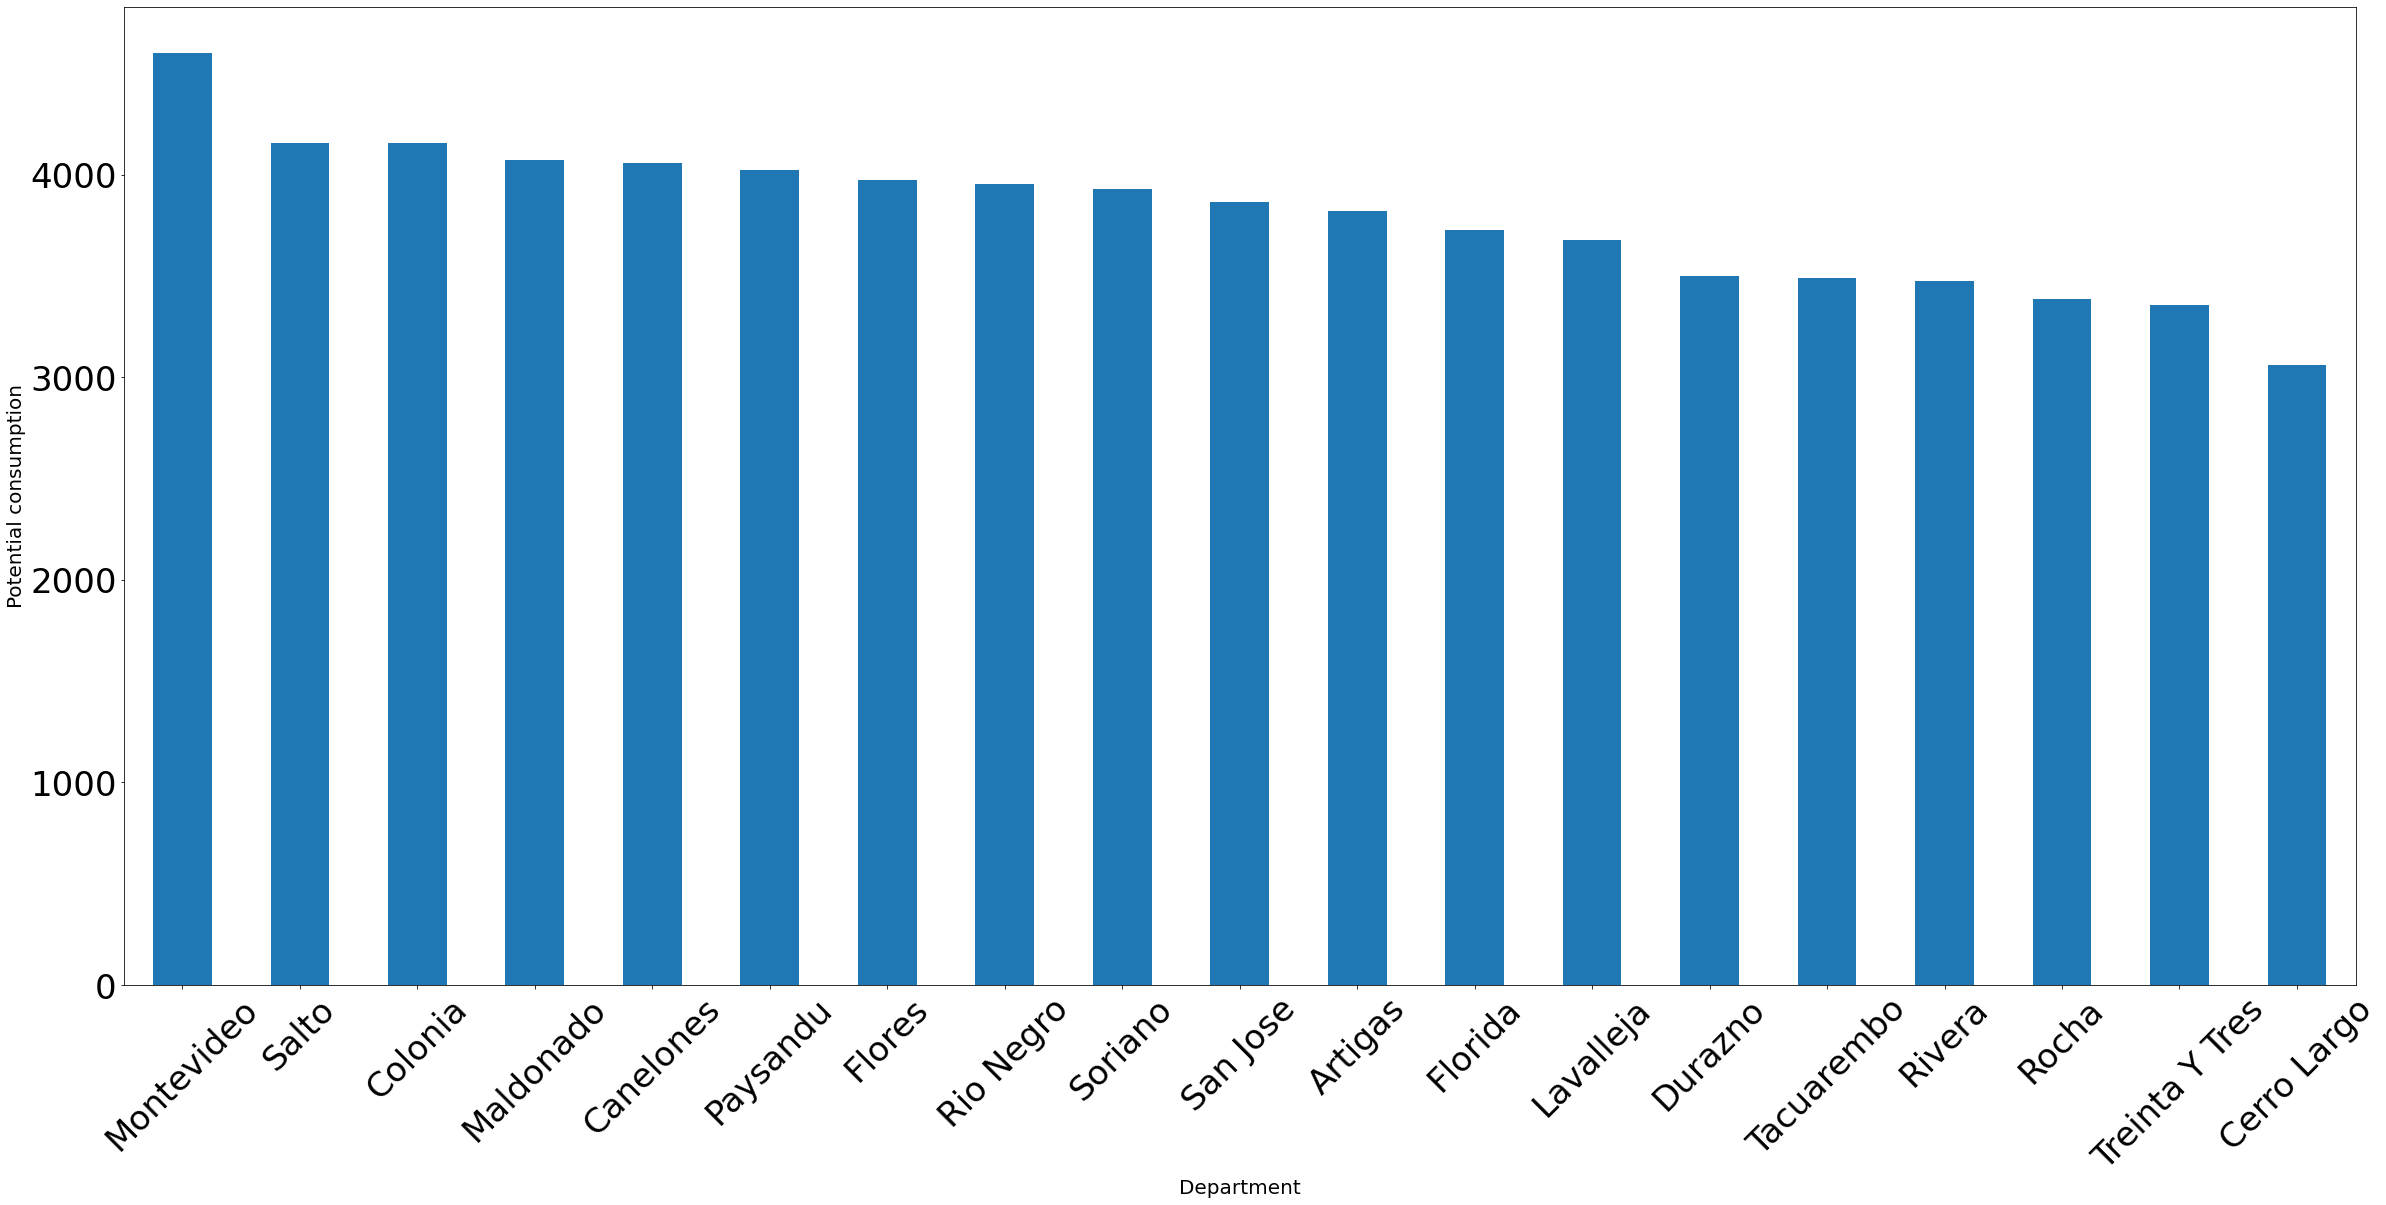

In [24]:
# Bar graph
ax = geodfDeptosConsumoAggregated[["DEPTO", "NOMBRE", "potentialconsum"]].sort_values(
        "potentialconsum", ascending=False
).plot.bar(
    x='NOMBRE', y='potentialconsum', rot=45, subplots=True,
    title="", figsize=(40, 18), legend=False, fontsize=34
)
ax = ax[0]
ax.set_title("")
ax.set_xlabel("Department")
ax.set_ylabel("Potential consumption")

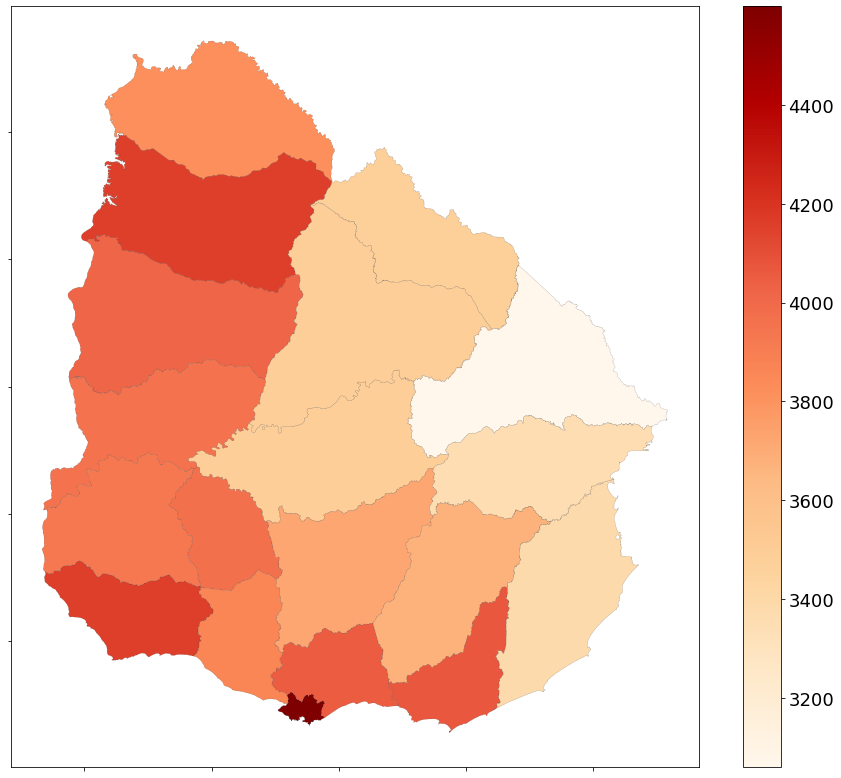

In [25]:
# Map plot
matplotlib.rcParams.update({'font.size': 18})
colormap = cm.OrRd

geodfDeptosConsumoAggregated = GeoDataFrame(
    geodfDeptosConsumoAggregated, geometry=geodfDeptosConsumoAggregated.geometry
)
ax = geodfDeptosConsumoAggregated.plot(
    column='potentialconsum',
    cmap=colormap,
    alpha=1,
    edgecolor='black',
    linewidth=0.1,
    figsize=(16, 14)
)
ax.set_xticklabels([])
ax.set_yticklabels([])

scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(geodfDeptosConsumoAggregated.potentialconsum)
ax_scale = plt.colorbar(scalarmappaple, orientation='vertical', pad=.05, ax=ax)

## By census section

In [26]:
geodfSectionConsumoAggregated = pd.merge(
    pd.DataFrame({"potentialconsum": df_ech_sec_consum.sum(axis=1)}),
    geoSecCen,
    left_index=True, right_on=["DEPTO", "SECCION"],
)
display(geodfSectionConsumoAggregated[["DEPTO", "SECCION", "NOMBDEPTO", "potentialconsum"]].sort_values(
    "potentialconsum", ascending=False
))

,DEPTO,SECCION,NOMBDEPTO,potentialconsum
9,1,10,Montevideo,5561.084396
17,1,18,Montevideo,5523.088919
23,1,24,Montevideo,5303.068994
13,1,14,Montevideo,4896.487158
5,1,6,Montevideo,4883.591925
11,1,12,Montevideo,4820.048756
22,1,23,Montevideo,4805.072581
0,1,1,Montevideo,4664.471591
6,1,7,Montevideo,4635.566000
14,1,15,Montevideo,4592.238358


In [27]:
pd.options.display.max_colwidth = 220
df = df_ech[df_ech.index == 1][["secc", "nombarrio"]].drop_duplicates().groupby("secc")["nombarrio"].apply(lambda x: " - ".join(x))

display(pd.DataFrame(df))

,nombarrio
secc,
1,Centro - Ciudad Vieja
2,Ciudad Vieja
3,Ciudad Vieja
4,Barrio Sur - Centro - Ciudad Vieja
5,Centro - Barrio Sur
6,Centro
7,Cordon - Palermo
8,Aguada
9,"Colon Centro y Noroeste - Lezica, Melilla - Colon Sureste, Abayuba"


In [28]:
sec_neigthbouthoods = pd.DataFrame(
    df_ech[df_ech.index == 1][["secc", "nombarrio"]].drop_duplicates().groupby("secc")["nombarrio"].apply(
        lambda x: " - ".join(x)
    )
)
display(
    geodfSectionConsumoAggregated[["DEPTO", "SECCION", "NOMBDEPTO", "potentialconsum"]].sort_values(
        "potentialconsum", ascending=False
    ).merge(
        sec_neigthbouthoods, left_on="SECCION", right_on="secc"
    )[["SECCION", "potentialconsum", "nombarrio"]]#.to_latex(index=False)
)

,SECCION,potentialconsum,nombarrio
0,10,5561.084396,Carrasco - Malvin - Buceo - Union - Malvin Norte - Punta Gorda - Las Canteras - Carrasco Norte
1,18,5523.088919,"Punta Carretas - Pocitos - Pque. Batlle, V. Dolores - Parque Rodo - Tres Cruces - Cordon"
2,24,5303.068994,"Pocitos - Buceo - Pque. Batlle, V. Dolores"
3,14,4896.487158,"Capurro, Bella Vista - Prado, Nueva Savona - Reducto"
4,6,4883.591925,Centro
5,12,4820.048756,"La Figurita - Reducto - Brazo Oriental - Larra¦aga - Atahualpa - Jacinto Vera - Mercado Modelo, Bolivar"
6,23,4805.072581,Tres Cruces - La Blanqueada - Larra¦aga
7,1,4664.471591,Centro - Ciudad Vieja
8,7,4635.566000,Cordon - Palermo
9,15,4592.238358,Palermo - Cordon - Parque Rodo


Text(0, 0.5, 'Potential consumption')

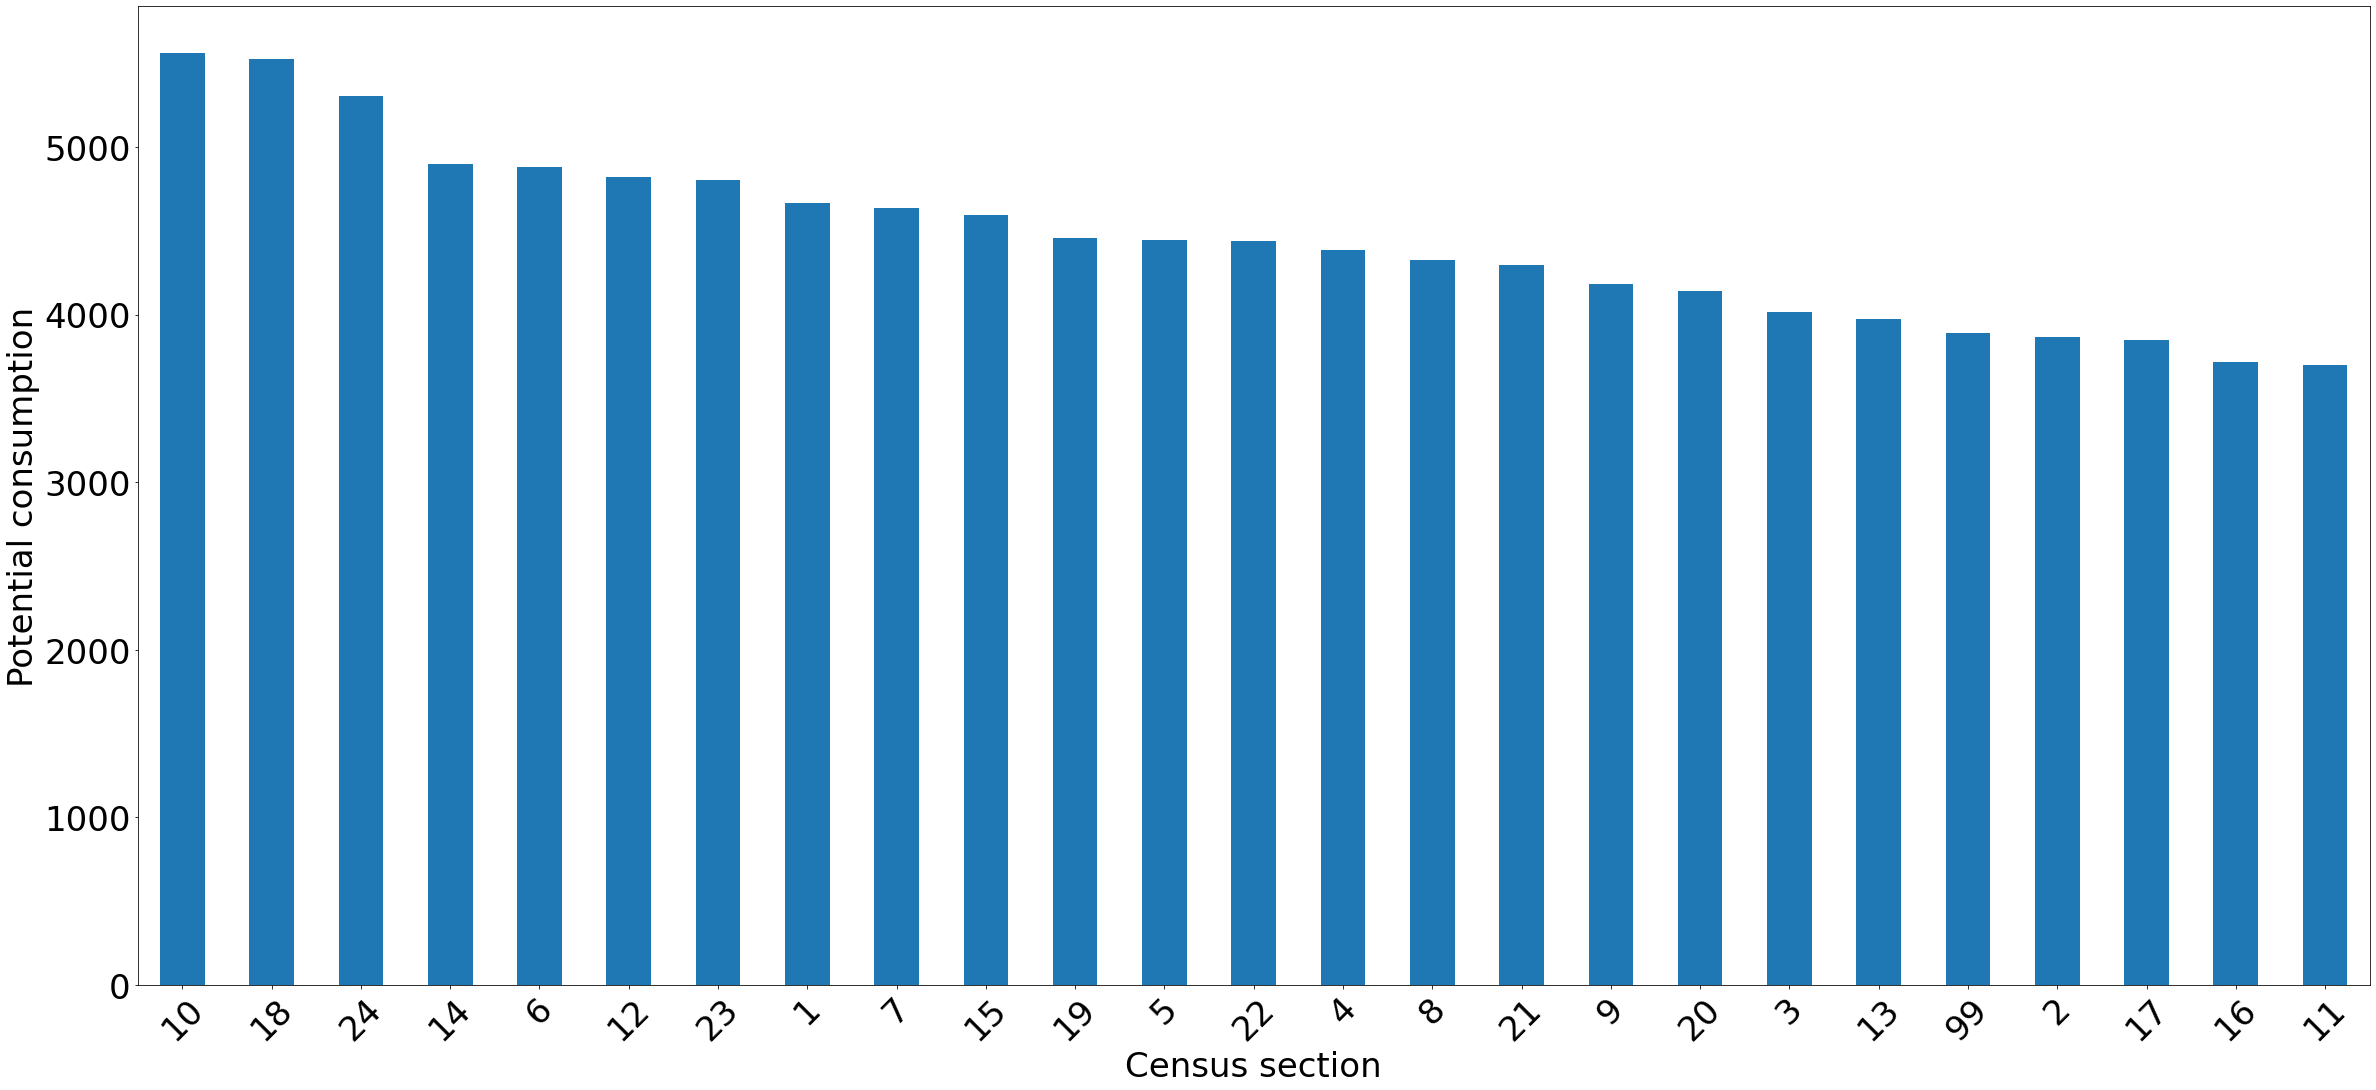

In [29]:
matplotlib.rcParams.update({'font.size': 34})

ax = geodfSectionConsumoAggregated[["DEPTO", "SECCION", "potentialconsum"]][lambda x: x.DEPTO == 1].sort_values(
        "potentialconsum", ascending=False
).plot.bar(
    x="SECCION", y='potentialconsum', rot=45, subplots=True,
    title="", figsize=(40, 18), legend=False, fontsize=34
)
ax = ax[0]
ax.set_title("")
ax.set_xlabel("Census section")
ax.set_ylabel("Potential consumption")

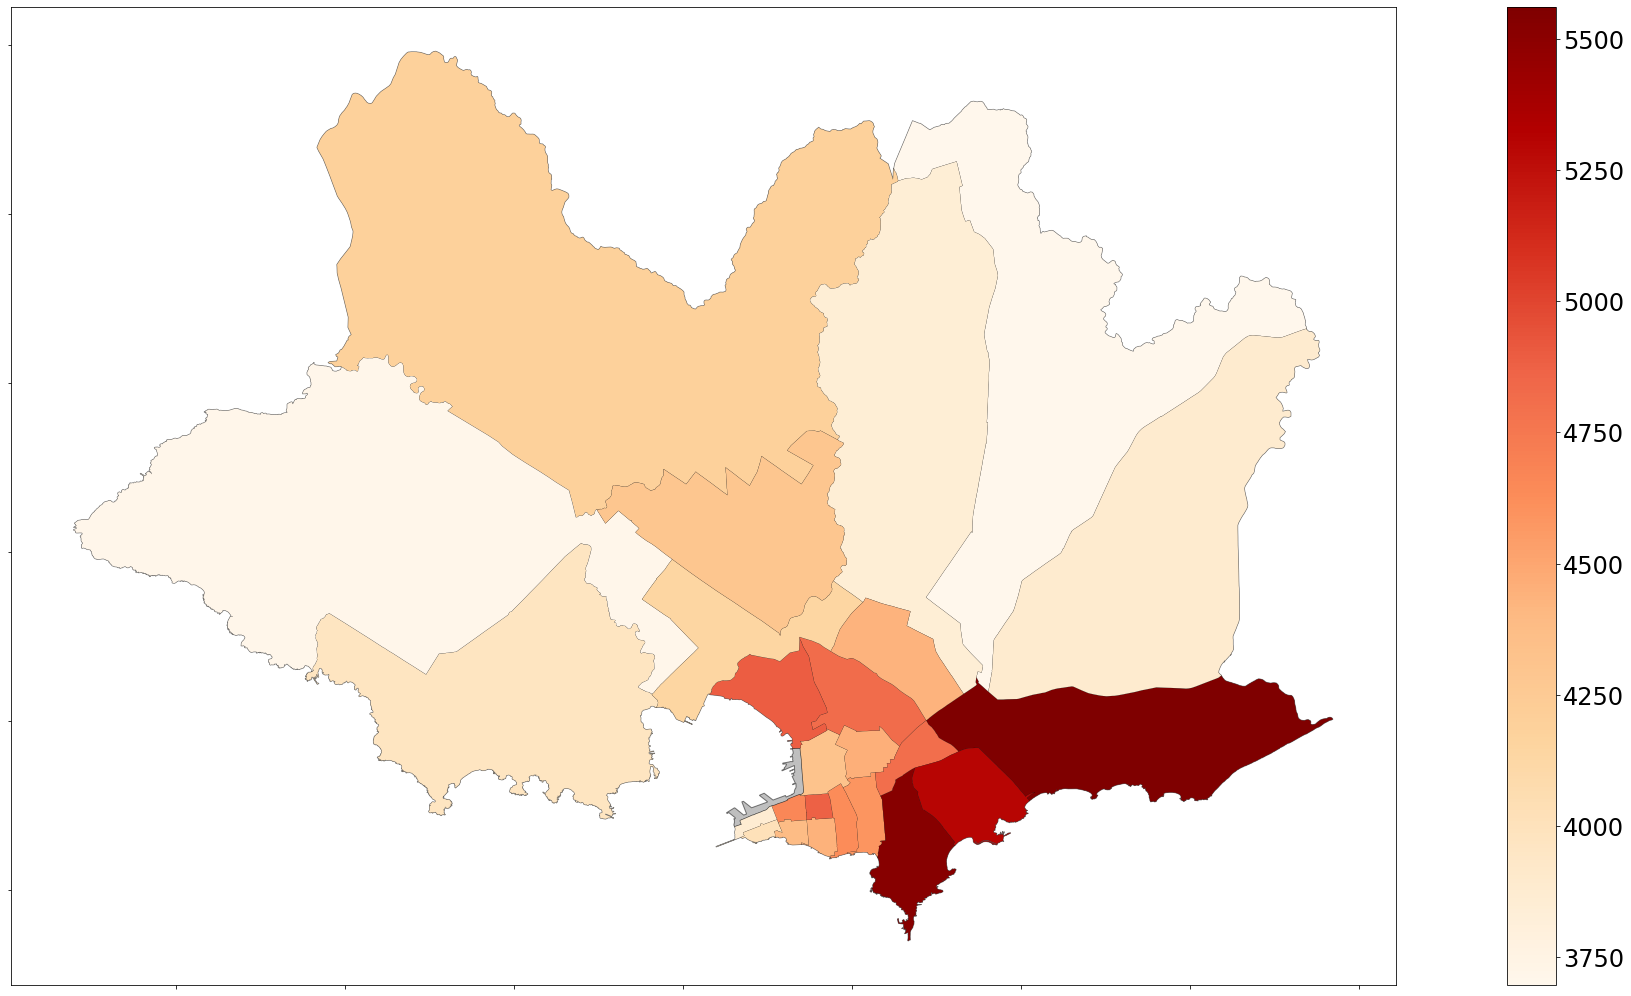

In [30]:
# Map plot
matplotlib.rcParams.update({'font.size': 24})
colormap = cm.OrRd

ax = GeoDataFrame(geoSecCen[geoSecCen.DEPTO==1]).plot(
    alpha=0.5, edgecolor='black', figsize=(40, 18), color="grey"
)

geodfSectionConsumoAggregated = GeoDataFrame(
    geodfSectionConsumoAggregated, geometry=geodfSectionConsumoAggregated.geometry
)
ax = geodfSectionConsumoAggregated.plot(
    column='potentialconsum',
    cmap=colormap,
    alpha=1,
    edgecolor='black',
    linewidth=0.1,
    figsize=(16, 14),
    ax=ax
)

ax.set_xticklabels([])
ax.set_yticklabels([])

scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(geodfSectionConsumoAggregated.potentialconsum)
ax_scale = plt.colorbar(scalarmappaple, orientation='vertical', pad=.05, ax=ax)

## By census segment

In [31]:
geodfSegmentConsumoAggregated = pd.merge(
    pd.DataFrame({"potentialconsum": df_ech_seg_consum.sum(axis=1)}),
    geoSegCen,
    left_index=True, right_on=["DEPTO", "SECCION", "SEGMENTO"],
)

display(
    geodfSegmentConsumoAggregated[
        ["DEPTO", "SECCION", "SEGMENTO", "NOMBDEPTO", "potentialconsum"]
    ]
    .merge(
        df_ech[["secc", "segm", "nombarrio"]],
        left_on=["DEPTO", "SECCION", "SEGMENTO"],
        right_on=["dpto","secc", "segm"],
    )
    .drop_duplicates()
    .sort_values(
        "potentialconsum", ascending=False
    )
)

,DEPTO,SECCION,SEGMENTO,NOMBDEPTO,potentialconsum,secc,segm,nombarrio
2400,1,10,75,Montevideo,10434.835714,10,75,Carrasco
2292,1,10,64,Montevideo,9380.580000,10,64,Carrasco
2359,1,10,66,Montevideo,8920.837500,10,66,Carrasco
2418,1,10,77,Montevideo,8800.220000,10,77,Carrasco
2375,1,10,73,Montevideo,8753.300000,10,73,Carrasco
...,...,...,...,...,...,...,...,...
1619,1,9,51,Montevideo,2405.537500,9,51,"Lezica, Melilla"
15550,1,99,208,Montevideo,2381.710000,99,208,Ba¦ados de Carrasco
1412,1,9,25,Montevideo,2081.172222,9,25,Colon Centro y Noroeste
3176,1,10,218,Montevideo,1344.150000,10,218,Union


Text(0, 0.5, 'Potential consumption')

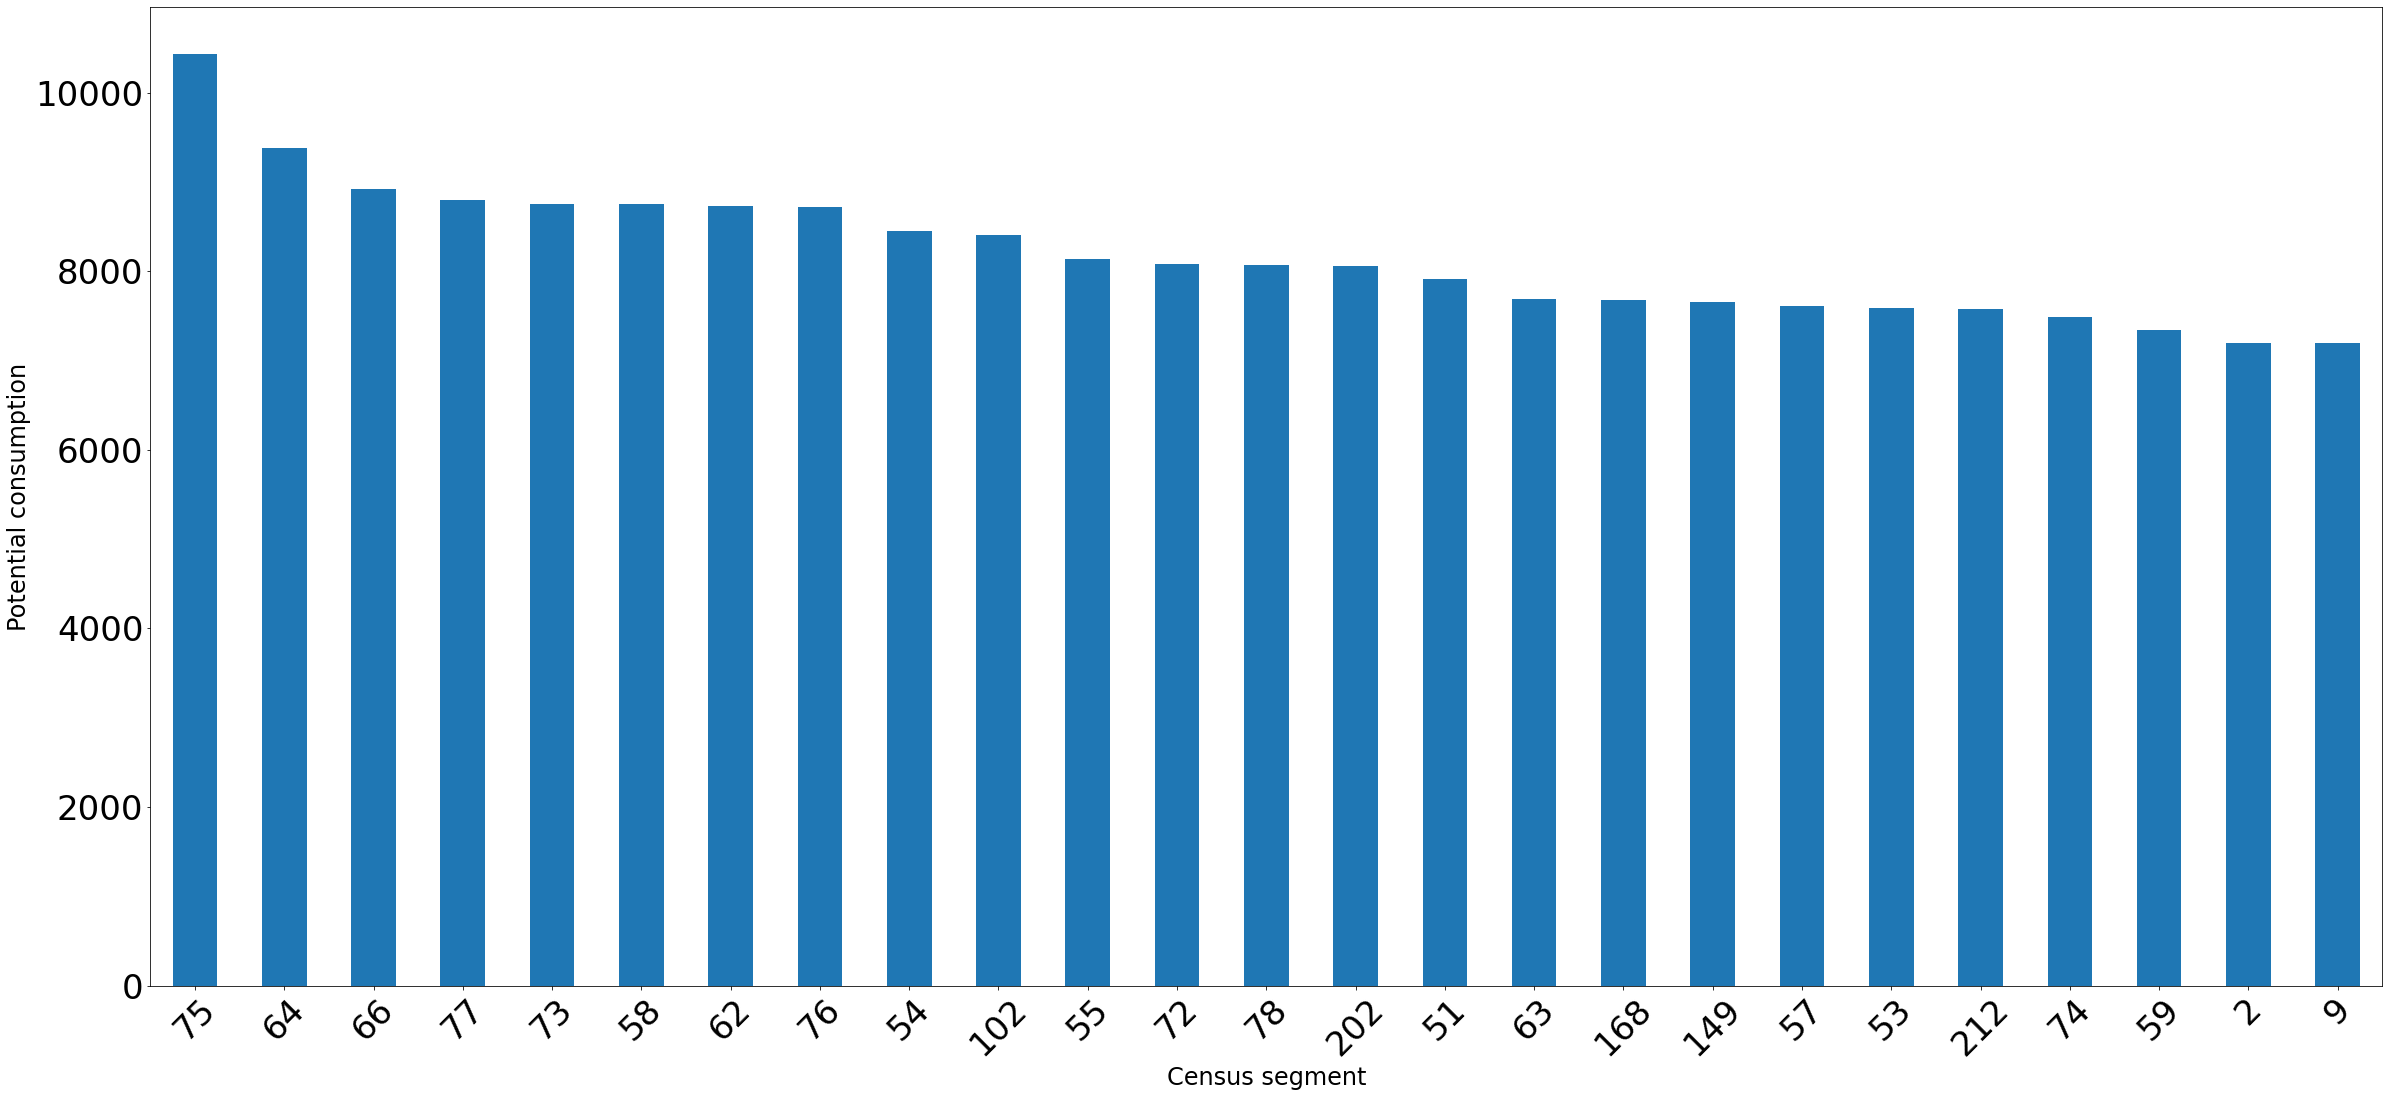

In [32]:
ax = geodfSegmentConsumoAggregated[["DEPTO", "SECCION", "SEGMENTO", "potentialconsum"]][lambda x: x.DEPTO == 1].sort_values(
        "potentialconsum", ascending=False
).iloc[:25].plot.bar(
    x="SEGMENTO", y='potentialconsum', rot=45, subplots=True,
    title="", figsize=(40, 18), legend=False, fontsize=34
)
ax = ax[0]
ax.set_title("")
ax.set_xlabel("Census segment")
ax.set_ylabel("Potential consumption")

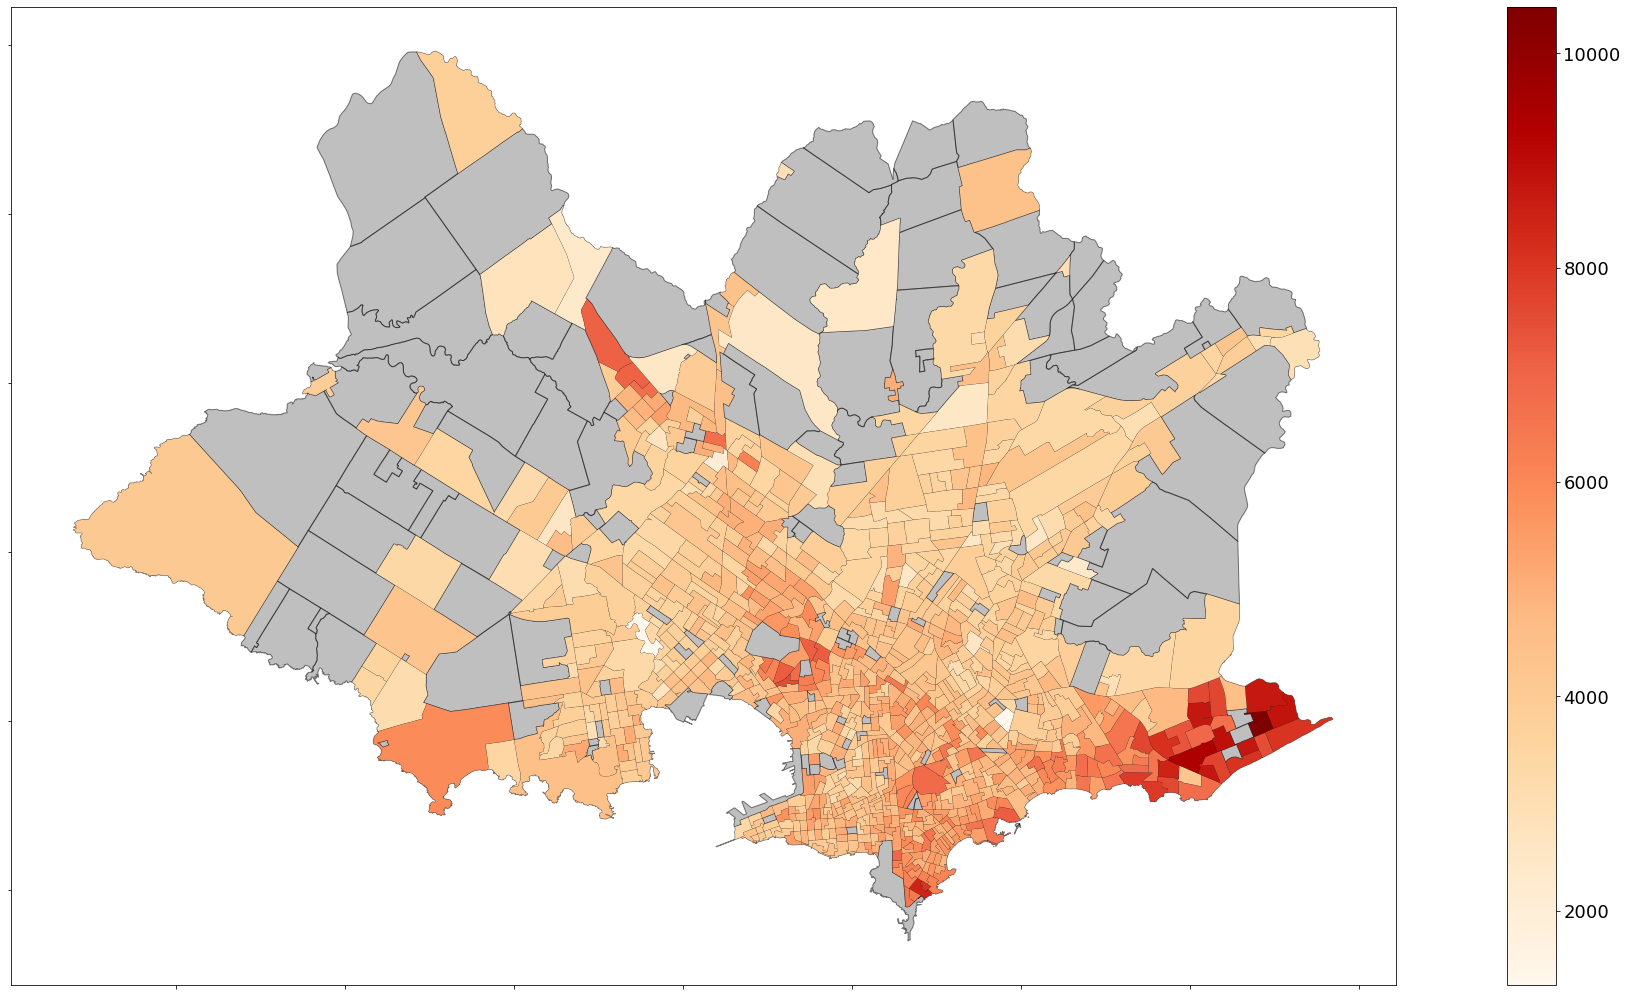

In [33]:
# Map plot
matplotlib.rcParams.update({'font.size': 18})
colormap = cm.OrRd

ax = GeoDataFrame(geoSegCen[geoSegCen.DEPTO==1]).plot(
    alpha=0.5, edgecolor='black', figsize=(40, 18), color="grey"
)

geodfSegmentConsumoAggregated = GeoDataFrame(
    geodfSegmentConsumoAggregated, geometry=geodfSegmentConsumoAggregated.geometry
)
ax = geodfSegmentConsumoAggregated.plot(
    column='potentialconsum',
    cmap=colormap,
    alpha=1,
    edgecolor='black',
    linewidth=0.1,
    figsize=(16, 14),
    ax=ax
)
ax.set_xticklabels([])
ax.set_yticklabels([])


scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(geodfSegmentConsumoAggregated.potentialconsum)
ax_scale = plt.colorbar(scalarmappaple, orientation='vertical', pad=.05, ax=ax)

# Validate potential consumption index with real consumption

## Load mean consumption data by areas

In [34]:
df_meanconsum_bydepartment = pd.read_csv(
    CONSUM_DATA_PATH + '/avg-monthly-consum-data_avg_consum_bydepartments.csv',
    dtype={
        'department': np.int16,
        'avg_consum_mean': np.float32,
        'avg_consum_std': np.float32,
        'qty_customers_count': np.int16,
    },
)

df_meanconsum_bysection = pd.read_csv(
    CONSUM_DATA_PATH + '/avg-monthly-consum-data_avg_consum_bysections.csv',
    dtype={
        'department': np.int16,
        'section': np.int16,
        'avg_consum_mean': np.float32,
        'avg_consum_std': np.float32,
        'qty_customers_count': np.int16,
    },
)

df_meanconsum_bysegment = pd.read_csv(
    CONSUM_DATA_PATH + '/avg-monthly-consum-data_avg_consum_bysegments.csv',
    dtype={
        'department': np.int16,
        'section': np.int16,
        'segment': np.int16,
        'avg_consum_mean': np.float32,
        'avg_consum_std': np.float32,
        'qty_customers_count': np.int16,
    },
)


## Plot areas with consumption data available

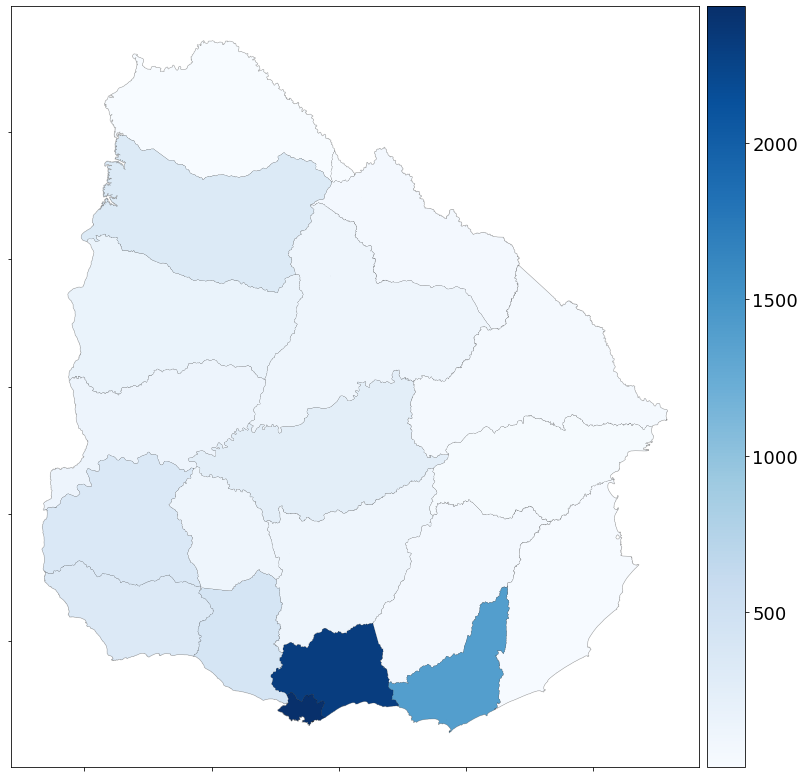

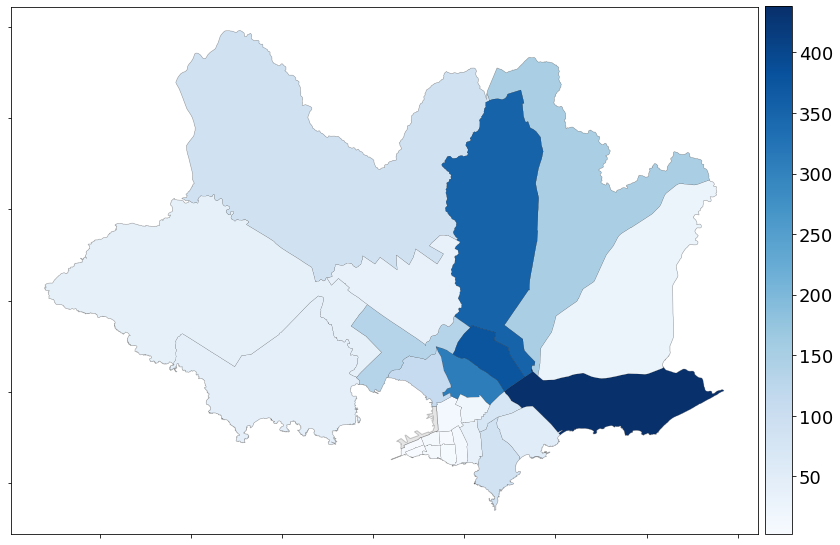

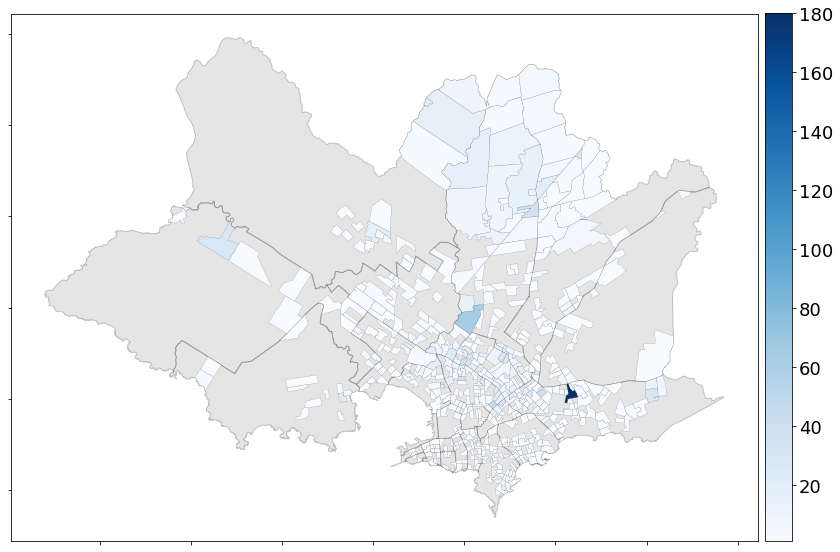

In [35]:
matplotlib.rcParams.update({'font.size': 18})

# DEPARTMENTS
# Full map (Uruguay)
ax_dept = GeoDataFrame(geoDepCen).plot(
    alpha=0.2, edgecolor='black', figsize=(15,14), color='grey'
)

colormap = cm.Blues
geoByDept = geoDepCen.merge(df_meanconsum_bydepartment, left_on="DEPTO", right_on="department", how="inner")
# print(geoByDept.head())
ax = GeoDataFrame(geoByDept).plot(
    column="qty_customers_count",
    ax=ax_dept,
    alpha=1,
    edgecolor='black',
    cmap=colormap,
    linewidth=0.1,
    figsize=(15,14)
)
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(geoByDept.qty_customers_count)
ax_scale = plt.colorbar(scalarmappaple, orientation='vertical', pad=.01, ax=ax)

# SECTIONS
# Full map (Montevideo sections)
ax_sec = GeoDataFrame(geoSecCen[geoSecCen.DEPTO==1]).plot(
    alpha=0.2, edgecolor='black', figsize=(14,14), color='grey'
)

colormap = cm.Blues
geoBySec = geoSecCen[geoSecCen.DEPTO==1].merge(
    df_meanconsum_bysection,
    left_on=["DEPTO", "SECCION"],
    right_on=["department", "section"],
    how="inner"
)
# print(geoBySec.head())
# print(geoBySec.shape)
ax = GeoDataFrame(geoBySec).plot(
    column="qty_customers_count",
    ax=ax_sec,
    alpha=1,
    edgecolor='black',
    cmap=colormap,
    linewidth=0.1,
    figsize=(14,14)
)
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(geoBySec.qty_customers_count)
ax_scale = plt.colorbar(scalarmappaple, orientation='vertical', pad=.01, ax=ax, fraction=0.0338)

# SEGMENTS
# Full map (Montevideo segments)
ax_seg = GeoDataFrame(geoSecCen[geoSecCen.DEPTO==1]).plot(
    alpha=0.2, edgecolor='black', figsize=(14,14), color='grey'
)

colormap = cm.Blues
geoBySeg = geoSegCen[geoSegCen.DEPTO==1].merge(
    df_meanconsum_bysegment,
    left_on=["DEPTO", "SECCION", "SEGMENTO"],
    right_on=["department", "section", "segment"],
    how="inner"
)
# print(geoBySeg.head())
# print(geoBySeg.shape)
ax = GeoDataFrame(geoBySeg).plot(
    column="qty_customers_count",
    ax=ax_seg,
    alpha=1,
    edgecolor='black',
    cmap=colormap,
    linewidth=0.1,
    figsize=(14,14)
)
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(geoBySeg.qty_customers_count)
ax_scale = plt.colorbar(scalarmappaple, orientation='vertical', pad=.01, ax=ax, fraction=0.0338)


_ = ax_dept.set_xticklabels([])
_ = ax_dept.set_yticklabels([])
_ = ax_sec.set_xticklabels([])
_ = ax_sec.set_yticklabels([])
_ = ax_seg.set_xticklabels([])
_ = ax_seg.set_yticklabels([])


## By department

,department,avg_consum_mean,avg_consum_std,qty_customers_count,DEPTO,NOMBRE
1,2,341.994904,40.025116,4,2,Artigas
0,1,225.796844,100.899284,2436,1,Montevideo
10,11,193.040573,101.813728,159,11,Paysandu
2,3,184.452957,105.102074,2303,3,Canelones
14,15,183.998718,105.857964,330,15,Salto
9,10,178.814438,91.576462,1396,10,Maldonado
16,17,177.444611,98.728668,364,17,Soriano
11,12,173.822250,102.201927,131,12,Rio Negro
7,8,171.638550,102.396202,119,8,Florida
12,13,167.737686,78.651947,55,13,Rivera


Text(0.5, 0, '')

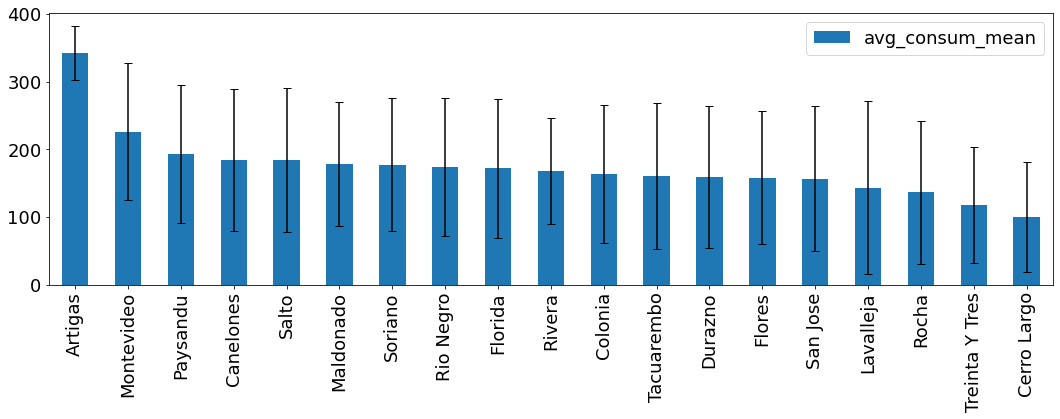

In [36]:
df_meanconsum_bydepartment = df_meanconsum_bydepartment[["department","avg_consum_mean","avg_consum_std","qty_customers_count"]].merge(
    geodfDeptosConsumoAggregated[["DEPTO", "NOMBRE"]], left_on="department", right_on="DEPTO"
)
display(df_meanconsum_bydepartment.sort_values("avg_consum_mean", ascending=False))

ax = df_meanconsum_bydepartment.sort_values("avg_consum_mean", ascending=False).plot.bar(
    x="NOMBRE", y="avg_consum_mean",
    yerr=df_meanconsum_bydepartment.set_index("NOMBRE")["avg_consum_std"], capsize=4, rot=90
)
ax.set_xlabel("")


### Analyze correlation

In [37]:
import statsmodels.api as sm

In [38]:
def calc_ols(min_qty_cust):
    tmp_dep = geodfDeptosConsumoAggregated.merge(
        df_meanconsum_bydepartment[df_meanconsum_bydepartment.qty_customers_count >= min_qty_cust],
        how="inner",
        left_on=["DEPTO"],
        right_on=["DEPTO"],
    ).set_index(
        ["DEPTO"]
    )[["avg_consum_mean", "potentialconsum"]]

    tmp_dep.sort_values("avg_consum_mean", inplace=True)

#     print(tmp_dep.head(30))
#     print(tmp_dep.shape)

    y_dep = tmp_dep["avg_consum_mean"]
    X_dep = tmp_dep["potentialconsum"] # Indep. variable

    X_dep = sm.add_constant(X_dep)
    model_dep = sm.OLS(y_dep, X_dep)
    results_dep = model_dep.fit()
    
    return results_dep, tmp_dep

max_res = None
for x in [1,50,100, 150, 200, 250, 300, 350]:
    res, tmp_dep = calc_ols(x)
    print ("-> Results using departments represented by at least {} customers:".format(x))
#     print('Parameters: \n', res.params)
    print("Number of departments to process: {}".format(res.predict().shape[0]))
    print('R2: ', res.rsquared)
    if max_res is None or res.rsquared > max_res.rsquared:
        max_res = res

results_dep = max_res
print(max_res.summary())

-> Results using departments represented by at least 1 customers:
Number of departments to process: 19
R2:  0.24404748195337
-> Results using departments represented by at least 50 customers:
Number of departments to process: 15
R2:  0.5603062604877795
-> Results using departments represented by at least 100 customers:
Number of departments to process: 13
R2:  0.5943726428702955
-> Results using departments represented by at least 150 customers:
Number of departments to process: 9
R2:  0.651745797865311
-> Results using departments represented by at least 200 customers:
Number of departments to process: 8
R2:  0.6955435755931797
-> Results using departments represented by at least 250 customers:
Number of departments to process: 8
R2:  0.6955435755931797
-> Results using departments represented by at least 300 customers:
Number of departments to process: 7
R2:  0.7714041557480859
-> Results using departments represented by at least 350 customers:
Number of departments to process: 5
R2:

/Users/jp/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


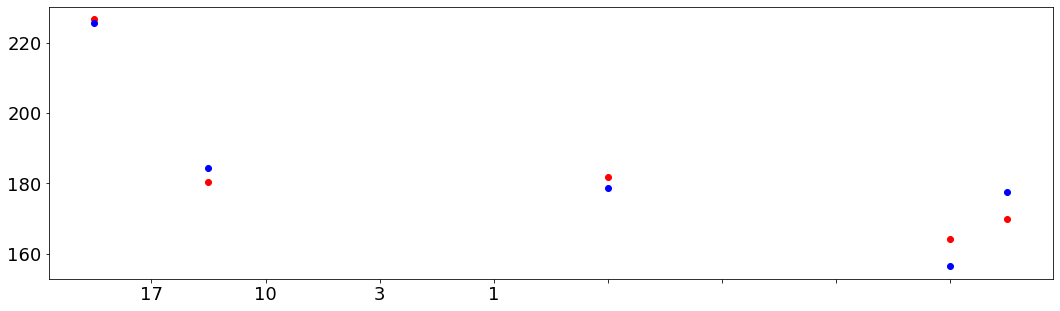

In [39]:
fig = plt.figure()
ax = plt.axes()

ax.plot(tmp_dep.index.values, results_dep.predict(), 'o', color='red');
ax.plot(tmp_dep.index.values, tmp_dep["avg_consum_mean"], 'o', color='blue');
_ = ax.set_xticklabels(tmp_dep.index.values)

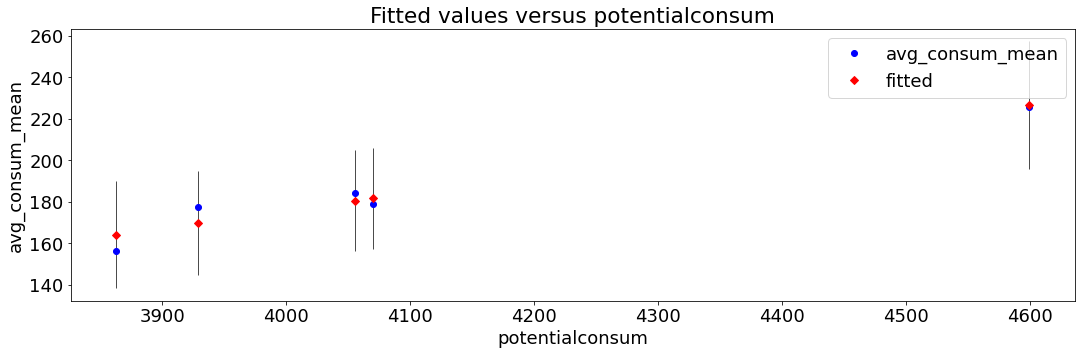

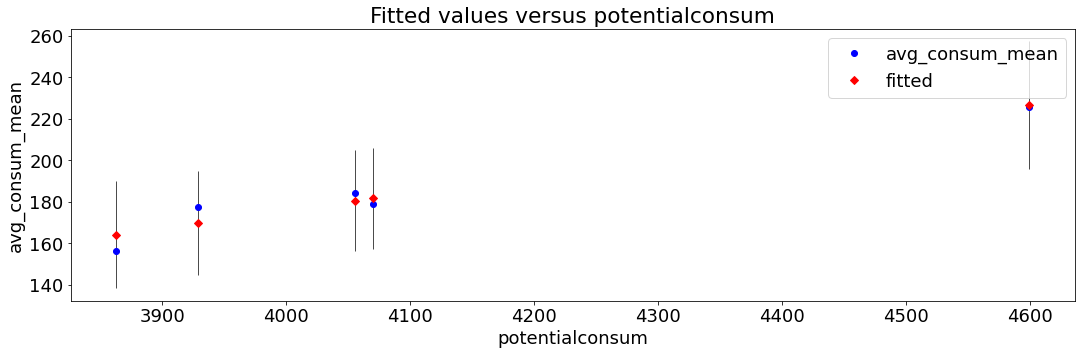

In [40]:
sm.graphics.plot_fit(results_dep, "potentialconsum")

## By census section

,department,section,avg_consum_mean,avg_consum_std,qty_customers_count,DEPTO,SECCION
0,1,1,282.784149,77.081635,10,1,1
1,1,2,245.161835,136.749893,4,1,2
2,1,3,182.225708,60.672413,2,1,3
3,1,4,224.218994,140.499512,9,1,4
4,1,5,257.036530,63.605015,7,1,5
5,1,6,188.852020,64.935577,5,1,6
6,1,7,217.975250,106.960564,11,1,7
7,1,8,246.895248,101.221146,13,1,8
8,1,9,227.379745,93.224724,88,1,9
9,1,10,224.283157,105.133545,438,1,10


Text(0.5, 0, '')

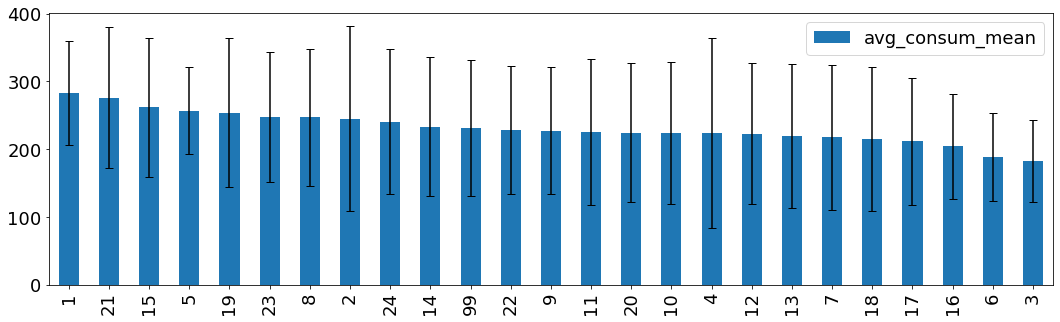

In [41]:
# print(geodfSectionConsumoAggregated.head())
df_meanconsum_bysection = df_meanconsum_bysection[["department", "section", "avg_consum_mean","avg_consum_std","qty_customers_count"]].merge(
    geodfSectionConsumoAggregated[["DEPTO", "SECCION"]],
    left_on=["department", "section"],
    right_on=["DEPTO", "SECCION"]
)
display(df_meanconsum_bysection)

ax = df_meanconsum_bysection.sort_values("avg_consum_mean", ascending=False).plot.bar(
    x="SECCION", y="avg_consum_mean",
    yerr=df_meanconsum_bysection.set_index("SECCION")["avg_consum_std"], capsize=4, rot=90
)
ax.set_xlabel("")


### Analyze correlation

In [42]:
def calc_ols(min_qty_cust):
    tmp_sec = geodfSectionConsumoAggregated.merge(
        df_meanconsum_bysection[df_meanconsum_bysection.qty_customers_count >= min_qty_cust],
        how="inner",
        left_on=["SECCION"],
        right_on=["SECCION"],
    ).set_index(
        ["SECCION"]
    )[["avg_consum_mean", "potentialconsum"]]

    tmp_sec.sort_values("avg_consum_mean", inplace=True)

#     print(tmp_sec.shape)
#     display(tmp_sec)

    y_sec = tmp_sec["avg_consum_mean"]
    X_sec = tmp_sec["potentialconsum"] # Indep. variable

    X_sec = sm.add_constant(X_sec)
    model = sm.OLS(y_sec, X_sec)
    results_sec = model.fit()
    return results_sec, tmp_sec

max_res = None
for x in [1,50,100, 200, 300]:  # sort(df_meanconsum_bysection.qty_customers_count.unique())
    res, tmp_sec = calc_ols(x)
    print ("-> Results using sections represented by at least {} customers:".format(x))
#     print('Parameters: \n', res.params)
    print("Number of sections to process: {}".format(res.predict().shape[0]))
    print('R2: ', res.rsquared)
    if max_res is None or res.rsquared > max_res.rsquared:
        max_res = res
        
results_sec = max_res
print(max_res.summary())

-> Results using sections represented by at least 1 customers:
Number of sections to process: 25
R2:  0.010542825968106628
-> Results using sections represented by at least 50 customers:
Number of sections to process: 11
R2:  0.05483104200879729
-> Results using sections represented by at least 100 customers:
Number of sections to process: 7
R2:  0.1608141829108808
-> Results using sections represented by at least 200 customers:
Number of sections to process: 4
R2:  0.3684646895175532
-> Results using sections represented by at least 300 customers:
Number of sections to process: 4
R2:  0.3684646895175532
                            OLS Regression Results                            
Dep. Variable:        avg_consum_mean   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.167
Date:                Sun, 14 Feb 2021   Prob (F-statistic):             

/Users/jp/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


[17 12 10 22]


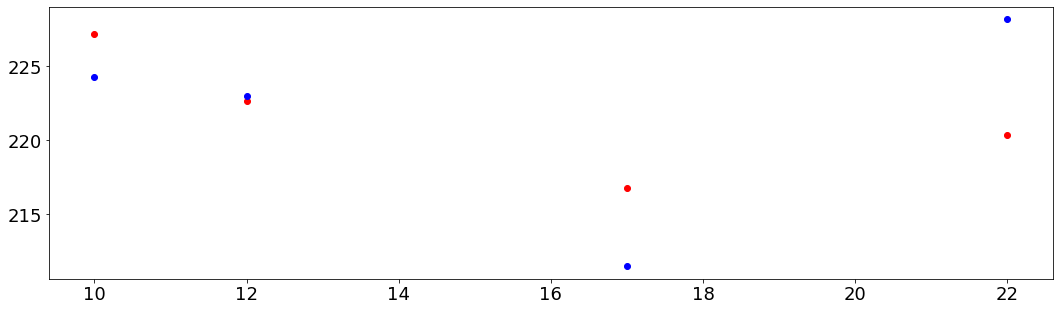

In [43]:
print(tmp_sec.index.values)

fig = plt.figure()
ax = plt.axes()

ax.plot(tmp_sec.index.values, results_sec.predict(), 'o', color='red');
ax.plot(tmp_sec.index.values, tmp_sec["avg_consum_mean"], 'o', color='blue');
# _ = ax.set_xticklabels(tmp.index.values)

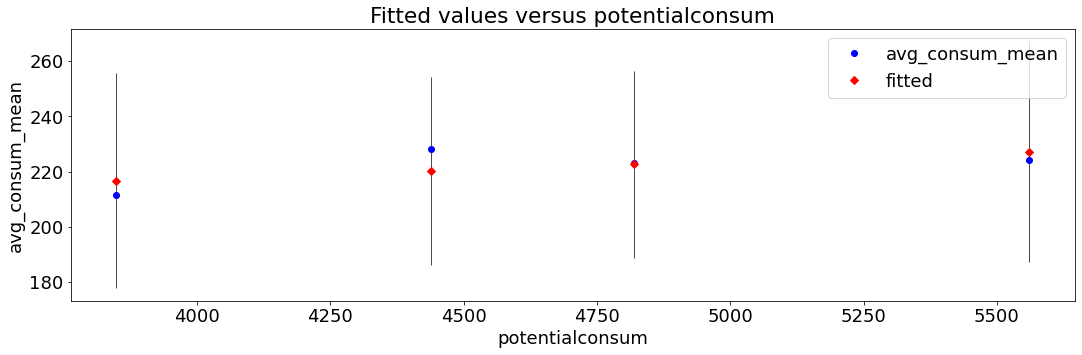

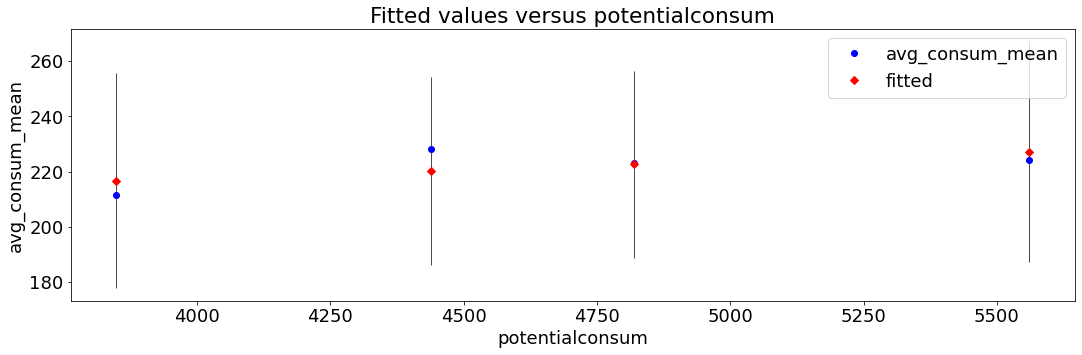

In [44]:
sm.graphics.plot_fit(results_sec, "potentialconsum")

## By census segment

,department,section,segment,avg_consum_mean,avg_consum_std,qty_customers_count,DEPTO,SECCION,SEGMENTO
0,1,1,1,298.528015,81.39431,3,1,1,1
1,1,1,2,149.971664,NaN,1,1,1,2
2,1,1,3,347.930023,NaN,1,1,1,3
3,1,1,104,249.193176,NaN,1,1,1,104
4,1,1,105,254.970413,NaN,1,1,1,105
...,...,...,...,...,...,...,...,...,...
459,1,99,155,303.721649,NaN,1,1,99,155
460,1,99,204,219.323410,NaN,1,1,99,204
461,1,99,210,54.009167,NaN,1,1,99,210
462,1,99,251,207.567581,NaN,1,1,99,251


Text(0.5, 0, '')

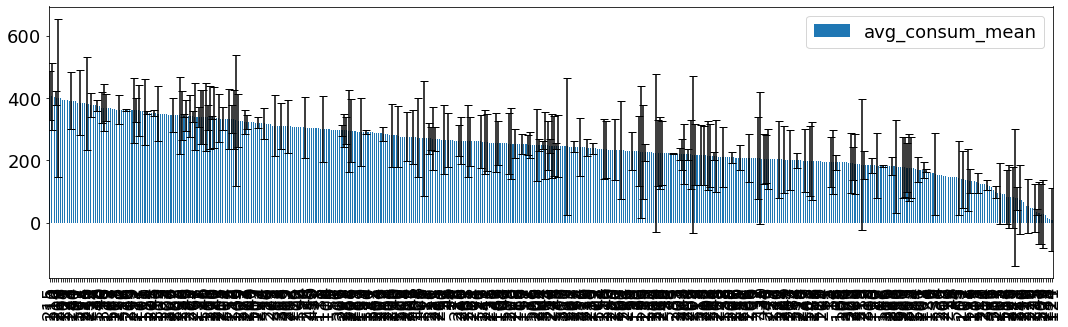

In [45]:
# print(geodfSectionConsumoAggregated.head())
df_meanconsum_bysegment = df_meanconsum_bysegment[["department", "section", "segment", "avg_consum_mean","avg_consum_std","qty_customers_count"]].merge(
    geodfSegmentConsumoAggregated[["DEPTO", "SECCION", "SEGMENTO"]][geodfSegmentConsumoAggregated.DEPTO == 1],
    left_on=["department", "section", "segment"],
    right_on=["DEPTO", "SECCION", "SEGMENTO"]
)
display(df_meanconsum_bysegment)

ax = df_meanconsum_bysegment.sort_values("avg_consum_mean", ascending=False).plot.bar(
    x="SEGMENTO", y="avg_consum_mean",
    yerr=df_meanconsum_bysegment["avg_consum_std"], capsize=4, rot=90
)
ax.set_xlabel("")


### Analyze correlation

In [46]:
def calc_ols(min_qty_cust):
    tmp_seg = geodfSegmentConsumoAggregated[geodfSegmentConsumoAggregated.DEPTO==1].merge(
        df_meanconsum_bysegment[df_meanconsum_bysegment.qty_customers_count >= min_qty_cust],
        how="inner",
        left_on=["SECCION", "SEGMENTO"],
        right_on=["SECCION", "SEGMENTO"],
    ).set_index(
        ["SEGMENTO"]
    )[["avg_consum_mean", "potentialconsum"]]

    tmp_seg.sort_values("avg_consum_mean", inplace=True)

#     print(tmp_seg.head())
#     print(tmp_seg.shape)

    y_seg = tmp_seg["avg_consum_mean"]
    X_seg = tmp_seg["potentialconsum"] # Indep. variable

    X_seg = sm.add_constant(X_seg)
    model_seg = sm.OLS(y_seg, X_seg)
    results_seg = model_seg.fit()
    
    return results_seg, tmp_seg

max_res = None
for x in [1,5,10,15,20,25]:  # sort(df_meanconsum_bysegment.qty_customers_count.unique()):
    res, tmp = calc_ols(x)
    print ("-> Results using segments represented by at least {} customers:".format(x))
#     print('Parameters: \n', res.params)
    print("Number of segments to process: {}".format(res.predict().shape[0]))
    print('R2: ', res.rsquared)
    if (max_res is None) or (res.rsquared > max_res.rsquared):
        max_res = res
        tmp_seg = tmp

results_seg = max_res
print(max_res.summary())

-> Results using segments represented by at least 1 customers:
Number of segments to process: 464
R2:  0.0004806377030710518
-> Results using segments represented by at least 5 customers:
Number of segments to process: 100
R2:  0.04120811178738615
-> Results using segments represented by at least 10 customers:
Number of segments to process: 67
R2:  0.03178673195775483
-> Results using segments represented by at least 15 customers:
Number of segments to process: 42
R2:  0.11256966008958158
-> Results using segments represented by at least 20 customers:
Number of segments to process: 29
R2:  0.13573095363050425
-> Results using segments represented by at least 25 customers:
Number of segments to process: 18
R2:  0.11225528941006546
                            OLS Regression Results                            
Dep. Variable:        avg_consum_mean   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.104
Method:                

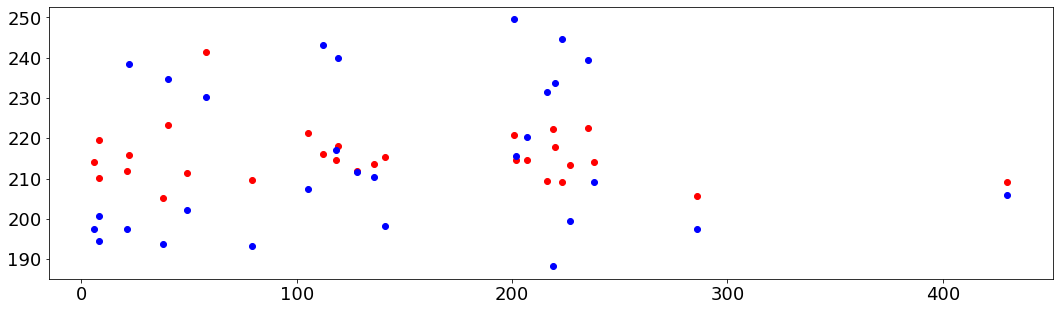

In [47]:
# print(tmp_seg.index.values)

fig = plt.figure()
ax = plt.axes()

ax.plot(tmp_seg.index.values, results_seg.predict(), 'o', color='red');
ax.plot(tmp_seg.index.values, tmp_seg["avg_consum_mean"], 'o', color='blue');
# _ = ax.set_xticklabels(tmp.index.values)

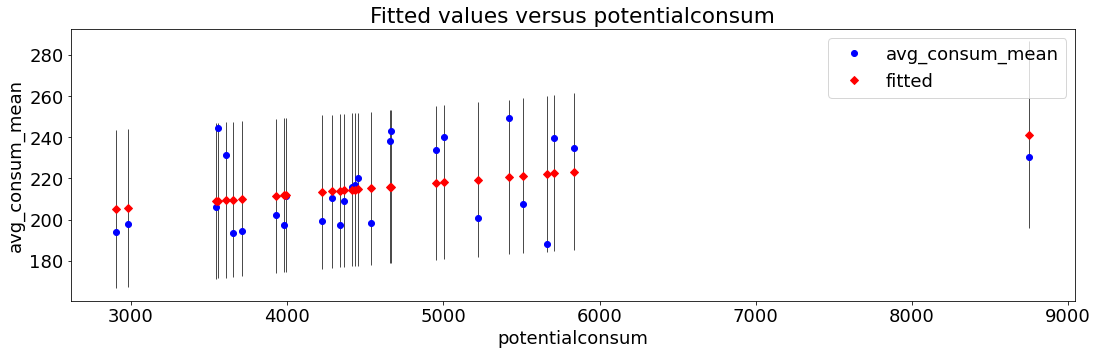

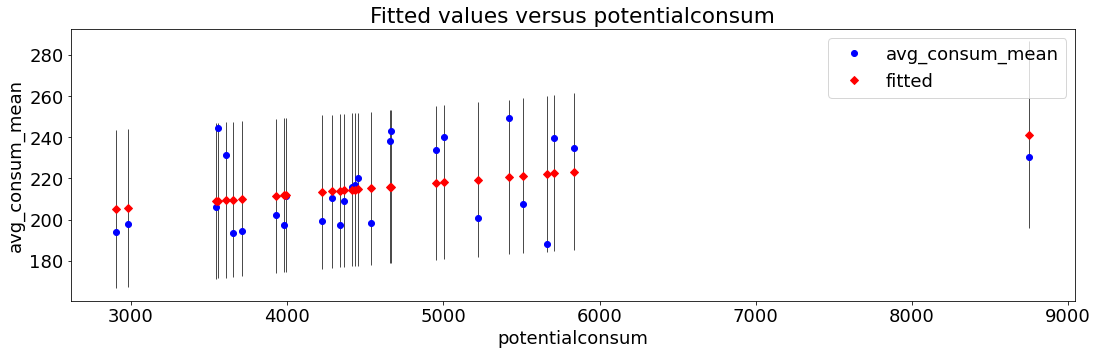

In [48]:
sm.graphics.plot_fit(results_seg, "potentialconsum")